In [19]:
!pip install dynamic_network_architectures
!pip install nnunetv2
!pip install mamba_ssm
!pip install triton

!pip install fvcore

  Using cached argparse-1.4.0-py2.py3-none-any.whl.metadata (2.8 kB)
Using cached argparse-1.4.0-py2.py3-none-any.whl (23 kB)


In [20]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import sys
sys.path.append('/kaggle/input/cm-unet')
from mamba_sys import MSAA  # 匯入 MSAA 模組
from mamba_sys import VSSM  # 載入 Mamba-based

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, UpSampling2D, BatchNormalization, SpatialDropout2D, Input, MaxPool2D, concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.applications import vgg16
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.data import Dataset, AUTOTUNE
import tensorflow.strings
from tensorflow.keras.utils import plot_model

import matplotlib.pyplot as plt

from glob import glob
from pathlib import Path
import os

Current status:

I'm trying to make a u_net that makes the mask for both the optical disk and cup
I'm trying to use tf datasets to do this
So far, based on some masks, it looks like it's treating the input image as the loss as well

In [21]:
PATH_TO_TRAINING = r'../input/drishtigs-retina-dataset-for-onh-segmentation/Training-20211018T055246Z-001/Training/'
PATH_TO_TRAINING_TENSOR = tf.Variable(PATH_TO_TRAINING)

TRAIN_GLAUCOMA_IMAGES = np.array(glob(os.path.join(PATH_TO_TRAINING, 'Images/GLAUCOMA/*')))
TRAIN_NORMAL_IMAGES = np.array(glob(os.path.join(PATH_TO_TRAINING, 'Images/NORMAL/*')))

TRAIN_GLAUCOMA_GT = np.array(glob(PATH_TO_TRAINING + '/GT/GALUCOMA/*'))
TRAIN_NORMAL_GT = np.array(glob(PATH_TO_TRAINING + '/GT/NORMAL/*'))

PATH_TO_TEST = r'../input/drishtigs-retina-dataset-for-onh-segmentation/Test-20211018T060000Z-001/Test'
TEST_GLAUCOMA_IMAGES = np.array(glob(os.path.join(PATH_TO_TEST, 'Images/glaucoma/*')))
TEST_NORMAL_IMAGES = np.array(glob(os.path.join(PATH_TO_TEST, 'Images/normal/*')))

SEED = 2
EPSILON = 10 ** -4
STATELESS_RNG= tf.random.Generator.from_seed(SEED, alg='philox')
IMAGE_SIZE = (224, 224)
CHANNELS = 3
SHUFFLE_BUFFER = len(TRAIN_NORMAL_IMAGES) + len(TRAIN_GLAUCOMA_IMAGES)
BATCH_SIZE = SHUFFLE_BUFFER // 2
early_stopping = EarlyStopping(monitor = 'val_loss', restore_best_weights = True, patience = 5)



In [22]:
Path(TRAIN_GLAUCOMA_IMAGES[0]).stem
TEST_GLAUCOMA_IMAGES

array(['../input/drishtigs-retina-dataset-for-onh-segmentation/Test-20211018T060000Z-001/Test/Images/glaucoma/drishtiGS_054.png',
       '../input/drishtigs-retina-dataset-for-onh-segmentation/Test-20211018T060000Z-001/Test/Images/glaucoma/drishtiGS_048.png',
       '../input/drishtigs-retina-dataset-for-onh-segmentation/Test-20211018T060000Z-001/Test/Images/glaucoma/drishtiGS_071.png',
       '../input/drishtigs-retina-dataset-for-onh-segmentation/Test-20211018T060000Z-001/Test/Images/glaucoma/drishtiGS_006.png',
       '../input/drishtigs-retina-dataset-for-onh-segmentation/Test-20211018T060000Z-001/Test/Images/glaucoma/drishtiGS_079.png',
       '../input/drishtigs-retina-dataset-for-onh-segmentation/Test-20211018T060000Z-001/Test/Images/glaucoma/drishtiGS_003.png',
       '../input/drishtigs-retina-dataset-for-onh-segmentation/Test-20211018T060000Z-001/Test/Images/glaucoma/drishtiGS_083.png',
       '../input/drishtigs-retina-dataset-for-onh-segmentation/Test-20211018T060000Z-001/T

In [23]:
def load_image_and_gt(path, test = False):
    '''
    Takes a path to the image,
    and returns the image alongside
    its ground truth
    '''
    
    print(path)
    
    filename = Path(path).stem
    if test:
        path_to_OD_softmap = os.path.join(PATH_TO_TEST, 'Test_GT', filename, 'SoftMap', filename + '_ODsegSoftmap.png')
        path_to_cup_softmap = os.path.join(PATH_TO_TEST, 'Test_GT', filename, 'SoftMap', filename + '_cupsegSoftmap.png')    
    else:
        path_to_OD_softmap = os.path.join(PATH_TO_TRAINING, 'GT', filename, 'SoftMap', filename + '_ODsegSoftmap.png')
        path_to_cup_softmap = os.path.join(PATH_TO_TRAINING, 'GT', filename, 'SoftMap', filename + '_cupsegSoftmap.png')
    image = tf.io.read_file(path)
    image = tf.io.decode_png(image)
    od = tf.io.read_file(path_to_OD_softmap)
    od = tf.io.decode_png(od)
    cup = tf.io.read_file(path_to_cup_softmap)
    cup = tf.io.decode_png(cup)
    return image, od, cup

def show_image_with_masks(image, od, cup, ax, index, label):
    '''
    Plots the real world image
    And the two masks
    Also shows the image after
    being masked with each mask
    Requires len(ax) >= 5
    '''
    ax[5 * index].imshow(image)
    ax[5 * index].set_title(label)
    ax[5 * index + 1].imshow(od)
    ax[5 * index + 1].set_title('Optical Disk Mask')
    ax[5 * index + 2].imshow(od * image)
    ax[5 * index + 2].set_title('Image with OD Mask')
    ax[5 * index + 3].imshow(cup)
    ax[5 * index + 3].set_title('Cup Mask')
    ax[5 * index + 4].imshow(cup * image)
    ax[5 * index + 4].set_title('Image with CUP Mask')
    
def load_image_with_masks(path, dice = False, test = False):
    '''
    This is similar to the
    load image_with_gt function
    however uses pure tf functions
    for the use in datasets
    otherwise I'd have to run
    in eagerexecution
    '''
    
    filename = tf.strings.split(path, sep = '.')[-2]
    filename = tf.strings.split(filename, sep = '/')[-1]
    directory_path = tf.strings.split(path, sep = 'Images')[0]
    if test:
        softmap_path = tf.strings.join([directory_path, 'Test_GT/', filename, '/SoftMap/'])
    else:
        softmap_path = tf.strings.join([directory_path, 'GT/', filename, '/SoftMap/'])
    od_path = tf.strings.join([softmap_path, filename, '_ODsegSoftmap.png'])
    cup_path = tf.strings.join([softmap_path, filename, '_cupsegSoftmap.png'])
    image = tf.io.read_file(path)
    image = tf.io.decode_png(image, channels = 3)
    image = tf.image.resize(image, IMAGE_SIZE)
    image = image / 255.0
    
    od = tf.io.read_file(od_path)
    od = tf.io.decode_png(od, channels = 1)
    od = tf.image.resize(od, IMAGE_SIZE)
    od = od / 255.0
    if dice:
        od = tf.where(od >= 0.5, 1.0, 0.0)
    
    cup = tf.io.read_file(cup_path)
    cup = tf.io.decode_png(cup, channels = 1)
    cup = tf.image.resize(cup, IMAGE_SIZE)
    cup = cup / 255.0
    if dice:
        cup = tf.where(cup >= 0.5, 1.0, 0.0)
    
    return {'image' : image}, {'od' : od, 'cup' : cup}

def augment_images(image, od, cup, single_target = False):
    
    seeds = STATELESS_RNG.make_seeds(2)[0], STATELESS_RNG.make_seeds(2)[0]
    
    def augment(img, seeds):
        
        img = tf.image.stateless_random_flip_left_right(img, seeds[0])
        img = tf.image.stateless_random_flip_up_down(img, seeds[1])
        img = tf.image.resize_with_crop_or_pad(img, IMAGE_SIZE[0] + 20, IMAGE_SIZE[1] + 20)
        img = tf.image.stateless_random_crop(img, size = (*IMAGE_SIZE, img.shape[2]), seed = seeds[0])
        
        return img
    
    image = augment(image, seeds)
    od = augment(od, seeds)
    cup = augment(cup, seeds)
    
    if single_target:
        return image, od
    return {'image' : image}, {'od' : od, 'cup' : cup}
    

../input/drishtigs-retina-dataset-for-onh-segmentation/Training-20211018T055246Z-001/Training/Images/NORMAL/drishtiGS_042.png


TensorShape([1750, 2050, 3])

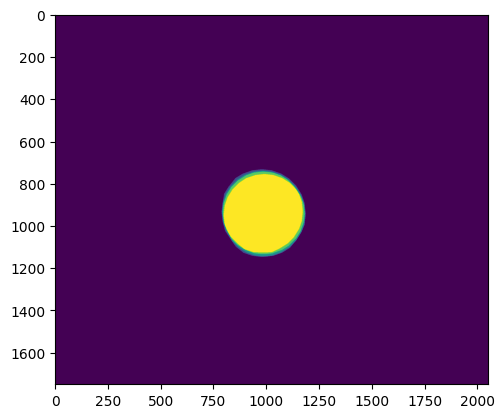

In [24]:
image, od, cup = load_image_and_gt(TRAIN_NORMAL_IMAGES[0])
plt.imshow(od)
image.shape

../input/drishtigs-retina-dataset-for-onh-segmentation/Training-20211018T055246Z-001/Training/Images/NORMAL/drishtiGS_089.png
../input/drishtigs-retina-dataset-for-onh-segmentation/Training-20211018T055246Z-001/Training/Images/NORMAL/drishtiGS_094.png
../input/drishtigs-retina-dataset-for-onh-segmentation/Training-20211018T055246Z-001/Training/Images/NORMAL/drishtiGS_035.png
../input/drishtigs-retina-dataset-for-onh-segmentation/Training-20211018T055246Z-001/Training/Images/GLAUCOMA/drishtiGS_076.png
../input/drishtigs-retina-dataset-for-onh-segmentation/Training-20211018T055246Z-001/Training/Images/GLAUCOMA/drishtiGS_010.png
../input/drishtigs-retina-dataset-for-onh-segmentation/Training-20211018T055246Z-001/Training/Images/GLAUCOMA/drishtiGS_064.png


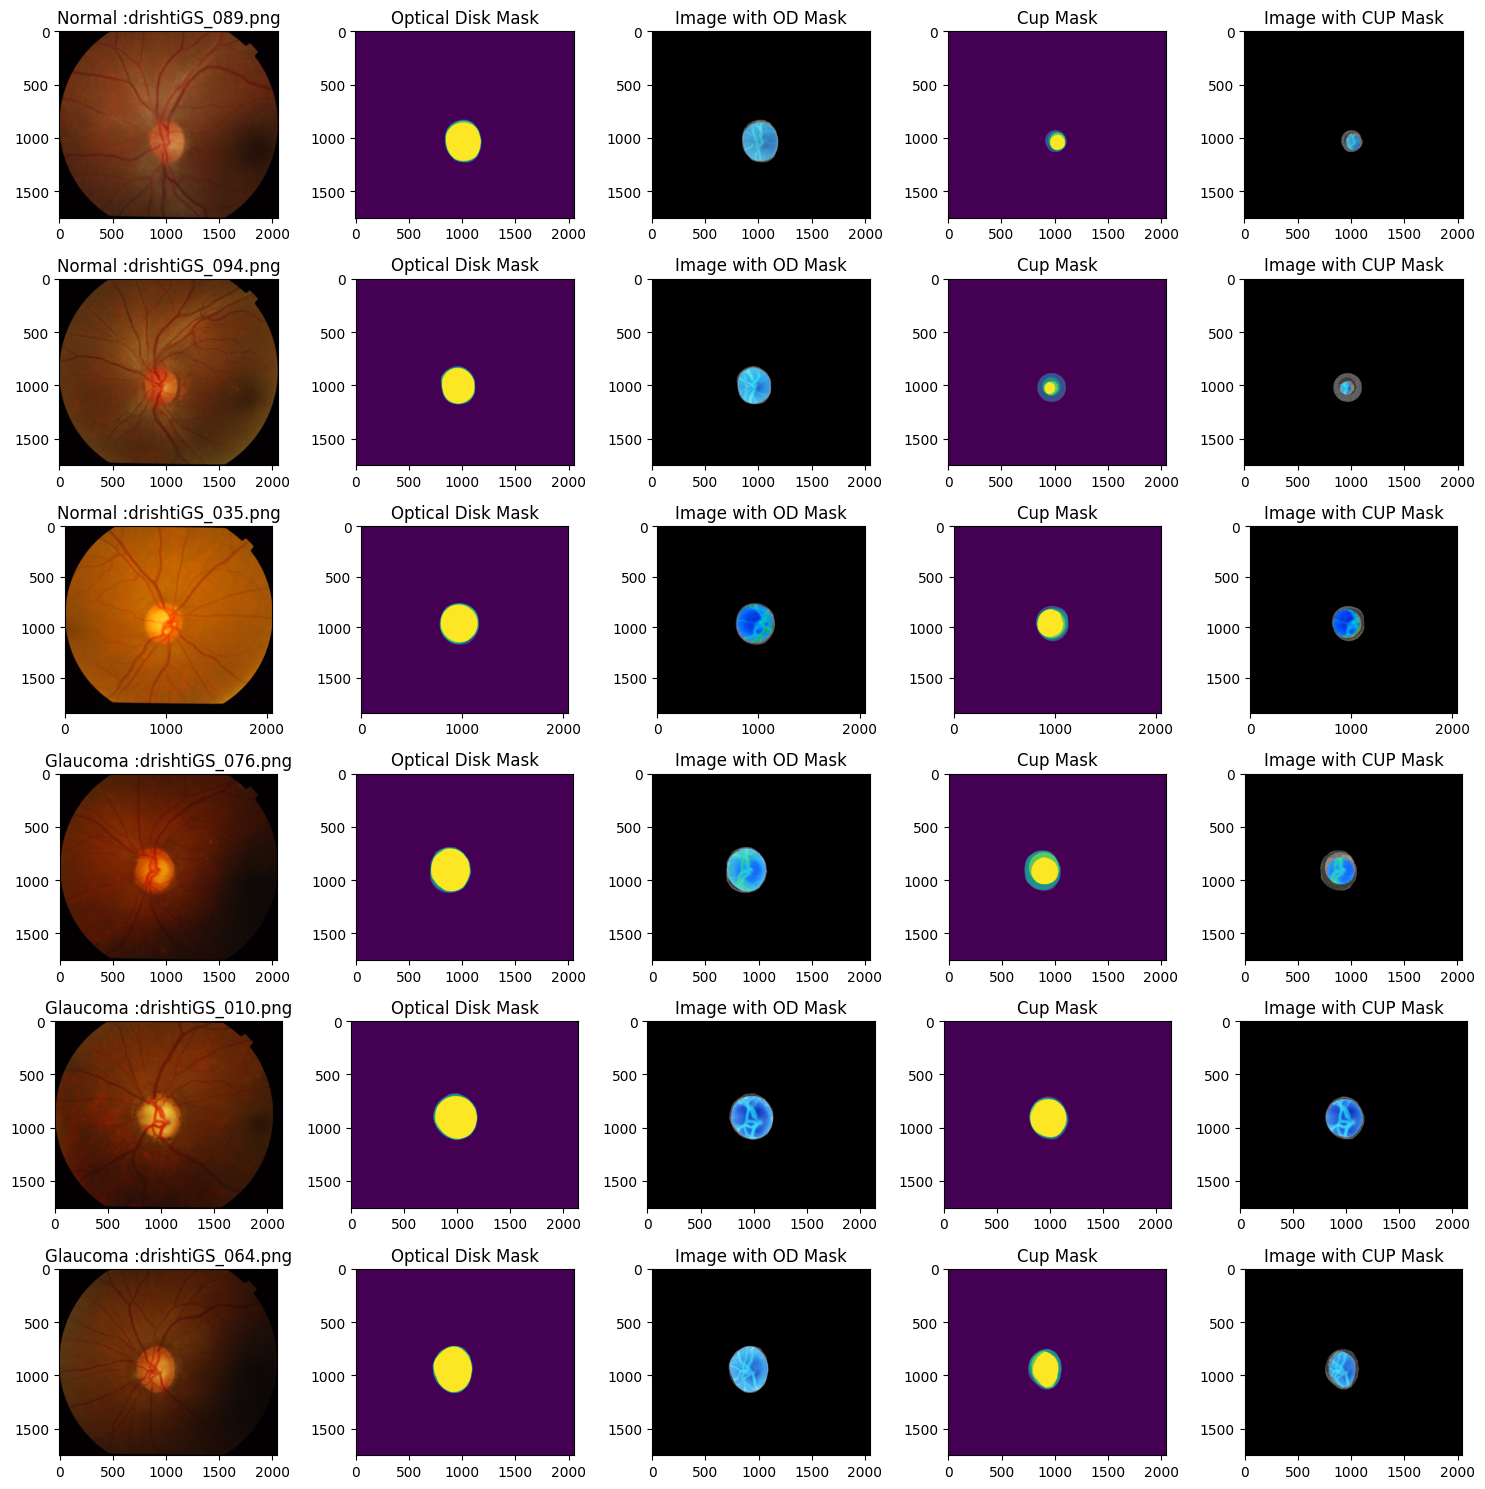

In [25]:
rows = 6
cols = 5
fig, axes = plt.subplots(rows, cols, figsize = (15, 15))
axes = axes.flatten()

normal_images = np.random.choice(TRAIN_NORMAL_IMAGES, rows // 2)
glaucoma_images = np.random.choice(TRAIN_GLAUCOMA_IMAGES, rows - (rows // 2))

for idx, file in enumerate(normal_images):
    image, od, cup = load_image_and_gt(file)
    show_image_with_masks(image, od, cup, axes, index = idx, label = 'Normal :' + os.path.basename(file))
    
for idx, file in enumerate(glaucoma_images):
    image, od, cup = load_image_and_gt(file)
    show_image_with_masks(image, od, cup, axes, index = idx + rows // 2, label = 'Glaucoma :' + os.path.basename(file))

plt.tight_layout()

So these images were using the Softmap folder. Let's ee what the AvgBoundary and CDR values look like.

In [26]:
def get_avgboundary(file):
    image = tf.io.read_file(file)
    image = tf.io.decode_png(image)
    
    cup_mask = np.zeros(shape = (image.shape[0], image.shape[1]))
    od_mask = np.zeros(shape = (image.shape[0], image.shape[1]))
    center_mask = np.zeros(shape = (image.shape[0], image.shape[1]))
    
    filename = Path(file).stem
    boundary_path = os.path.join(PATH_TO_TRAINING, 'GT', filename, 'AvgBoundary')
    cup_file = os.path.join(boundary_path, filename + '_CupAvgBoundary.txt')
    od_file = os.path.join(boundary_path, filename + '_ODAvgBoundary.txt')
    center_file = os.path.join(boundary_path, filename + '_diskCenter.txt')
    
    count = 0
    with open(cup_file) as cf:
        for line in cf:
            a, b = line.split()
            a = int(a)
            b = int(b)
            cup_mask[a, b] = 255
            count += 1

    with open(od_file) as of:
        for line in of:
            a, b = line.split()
            a = int(a)
            b = int(b)
            od_mask[a, b] = 255
        
    with open(center_file) as ctrf:
        for line in ctrf:
            a, b = line.split()
            a = int(a)
            b = int(b)
            center_mask[a, b] = 255
    return od_mask.reshape(image.shape[0], image.shape[1], 1), \
cup_mask.reshape(image.shape[0], image.shape[1], 1), center_mask.reshape(image.shape[0], image.shape[1], 1)
    

In [27]:
def get_avgboundary(file):
    image = tf.io.read_file(file)
    image = tf.io.decode_png(image)
    
    cup_mask = np.zeros(shape = (image.shape[0], image.shape[1]))
    od_mask = np.zeros(shape = (image.shape[0], image.shape[1]))
    center_mask = np.zeros(shape = (image.shape[0], image.shape[1]))
    
    filename = Path(file).stem
    boundary_path = os.path.join(PATH_TO_TRAINING, 'GT', filename, 'AvgBoundary')
    cup_file = os.path.join(boundary_path, filename + '_CupAvgBoundary.txt')
    od_file = os.path.join(boundary_path, filename + '_ODAvgBoundary.txt')
    center_file = os.path.join(boundary_path, filename + '_diskCenter.txt')
    
    count = 0
    with open(cup_file) as cf:
        for line in cf:
            a, b = line.split()
            a = int(a)
            b = int(b)
            cup_mask[a, b] = 255
            count += 1

    with open(od_file) as of:
        for line in of:
            a, b = line.split()
            a = int(a)
            b = int(b)
            od_mask[a, b] = 255
        
    with open(center_file) as ctrf:
        for line in ctrf:
            a, b = line.split()
            a = int(a)
            b = int(b)
            center_mask[a, b] = 255
    return od_mask.reshape(image.shape[0], image.shape[1], 1), \
cup_mask.reshape(image.shape[0], image.shape[1], 1), center_mask.reshape(image.shape[0], image.shape[1], 1)

In [28]:
glaucoma_avgboundary_test = TRAIN_GLAUCOMA_IMAGES[3]

od_mask, cup_mask, center_mask = get_avgboundary(glaucoma_avgboundary_test)
image, od, cup = load_image_and_gt(glaucoma_avgboundary_test)

../input/drishtigs-retina-dataset-for-onh-segmentation/Training-20211018T055246Z-001/Training/Images/GLAUCOMA/drishtiGS_004.png


In [29]:
glaucoma_avgboundary_test = TRAIN_GLAUCOMA_IMAGES[3]

od_mask, cup_mask, center_mask = get_avgboundary(glaucoma_avgboundary_test)
image, od, cup = load_image_and_gt(glaucoma_avgboundary_test)

../input/drishtigs-retina-dataset-for-onh-segmentation/Training-20211018T055246Z-001/Training/Images/GLAUCOMA/drishtiGS_004.png


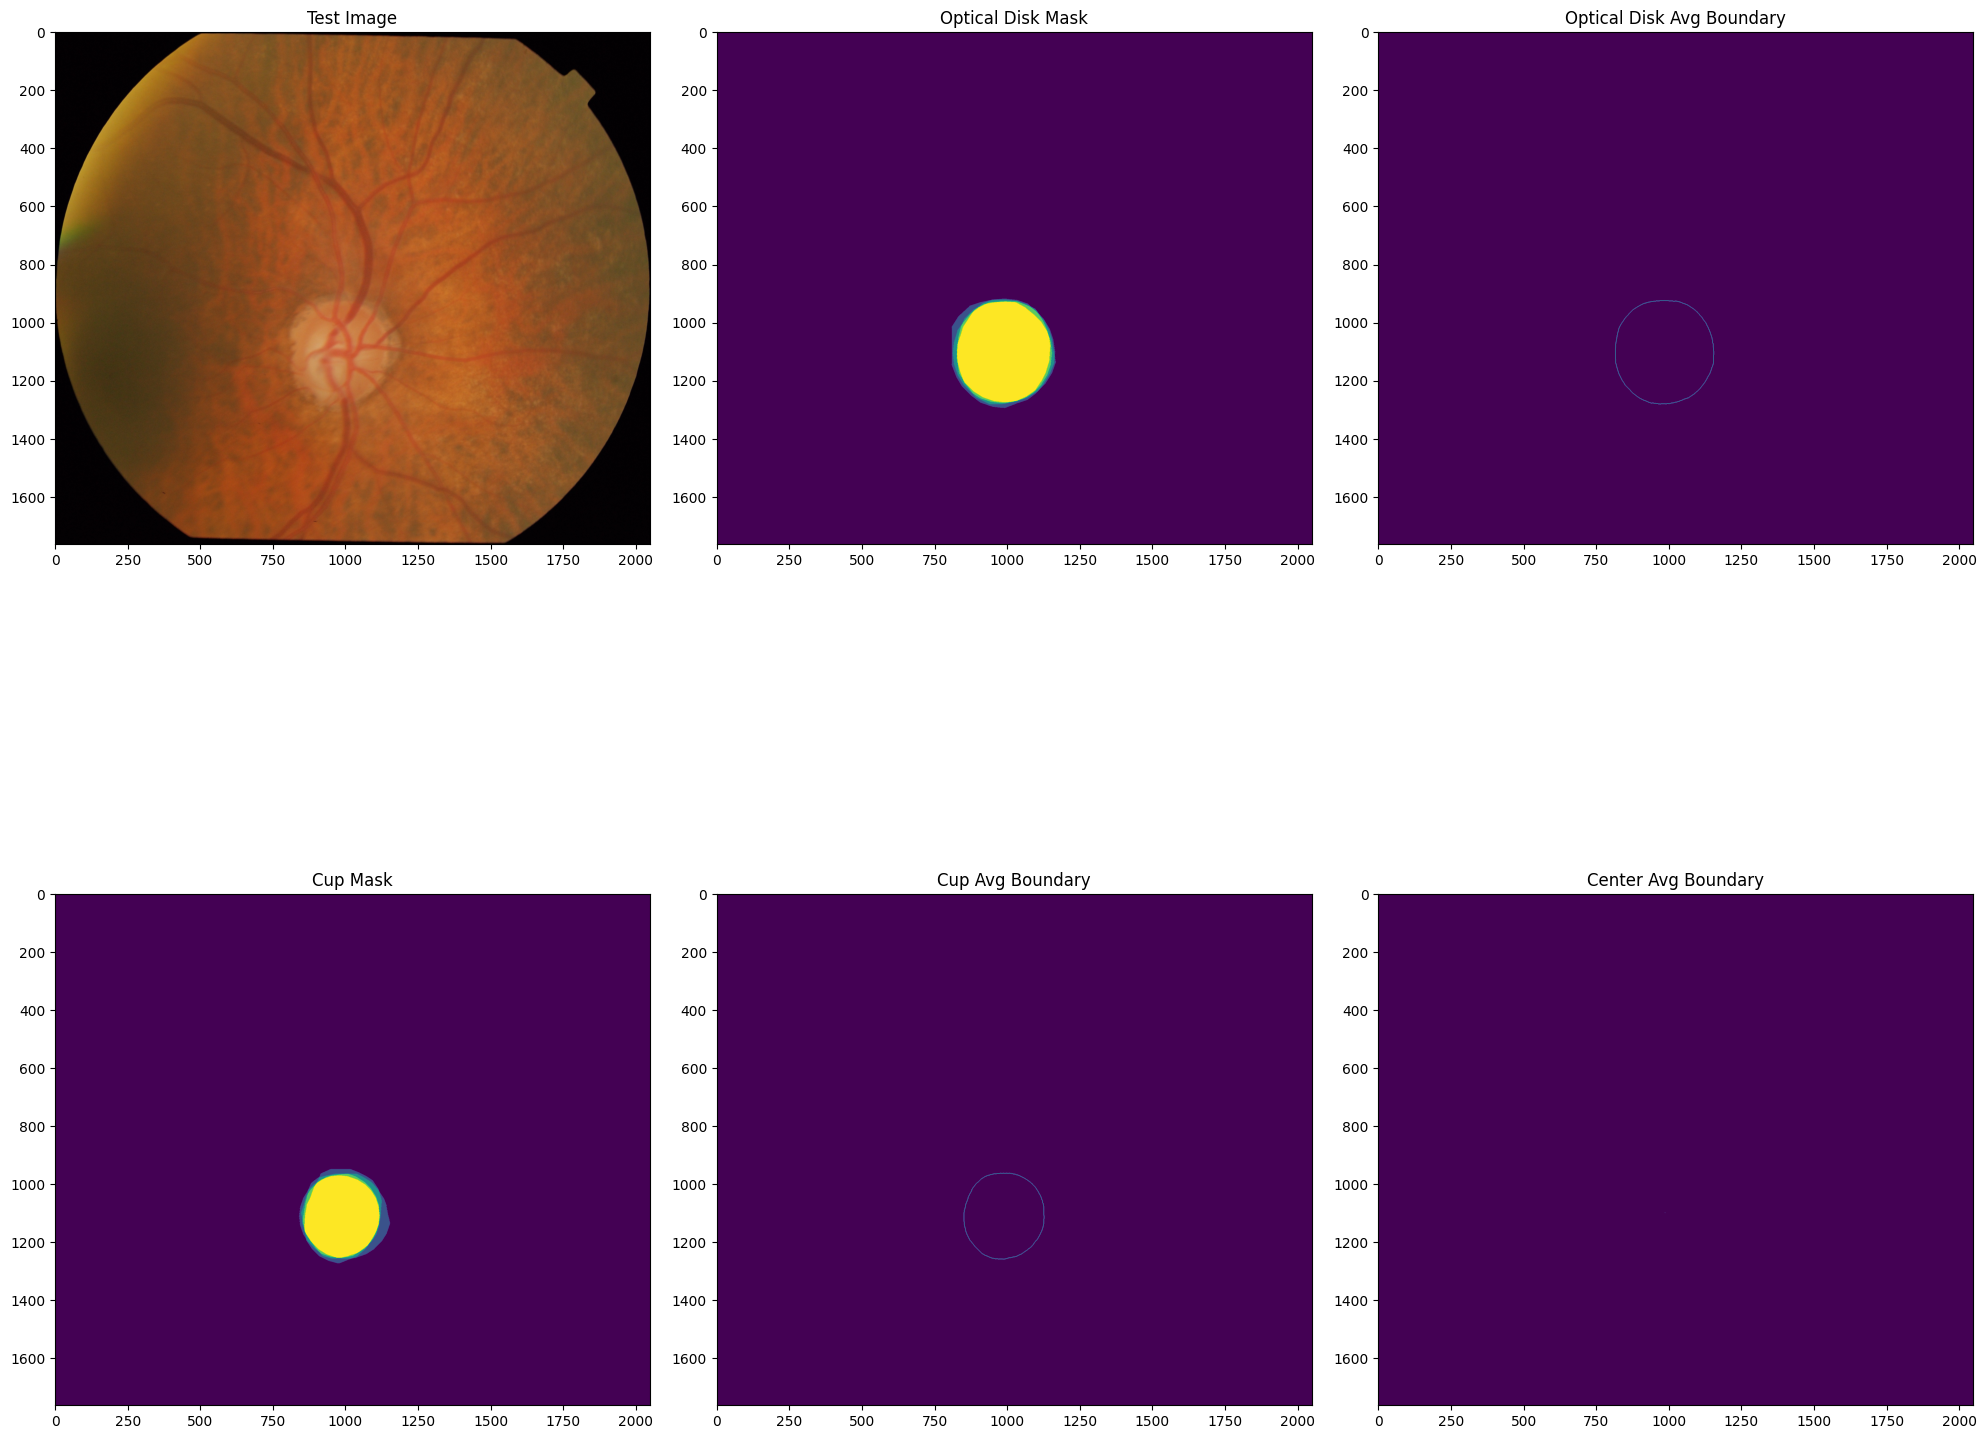

In [30]:
fig, axes = plt.subplots(2, 3, figsize = (20, 20))
axes = axes.flatten()

axes[0].imshow(image)
axes[0].set_title('Test Image')
axes[1].imshow(od)
axes[1].set_title('Optical Disk Mask')
axes[2].imshow(od_mask)
axes[2].set_title('Optical Disk Avg Boundary')
axes[3].imshow(cup)
axes[3].set_title('Cup Mask')
axes[4].imshow(cup_mask)
axes[4].set_title('Cup Avg Boundary')
axes[5].imshow(center_mask)
axes[5].set_title('Center Avg Boundary')
plt.tight_layout()

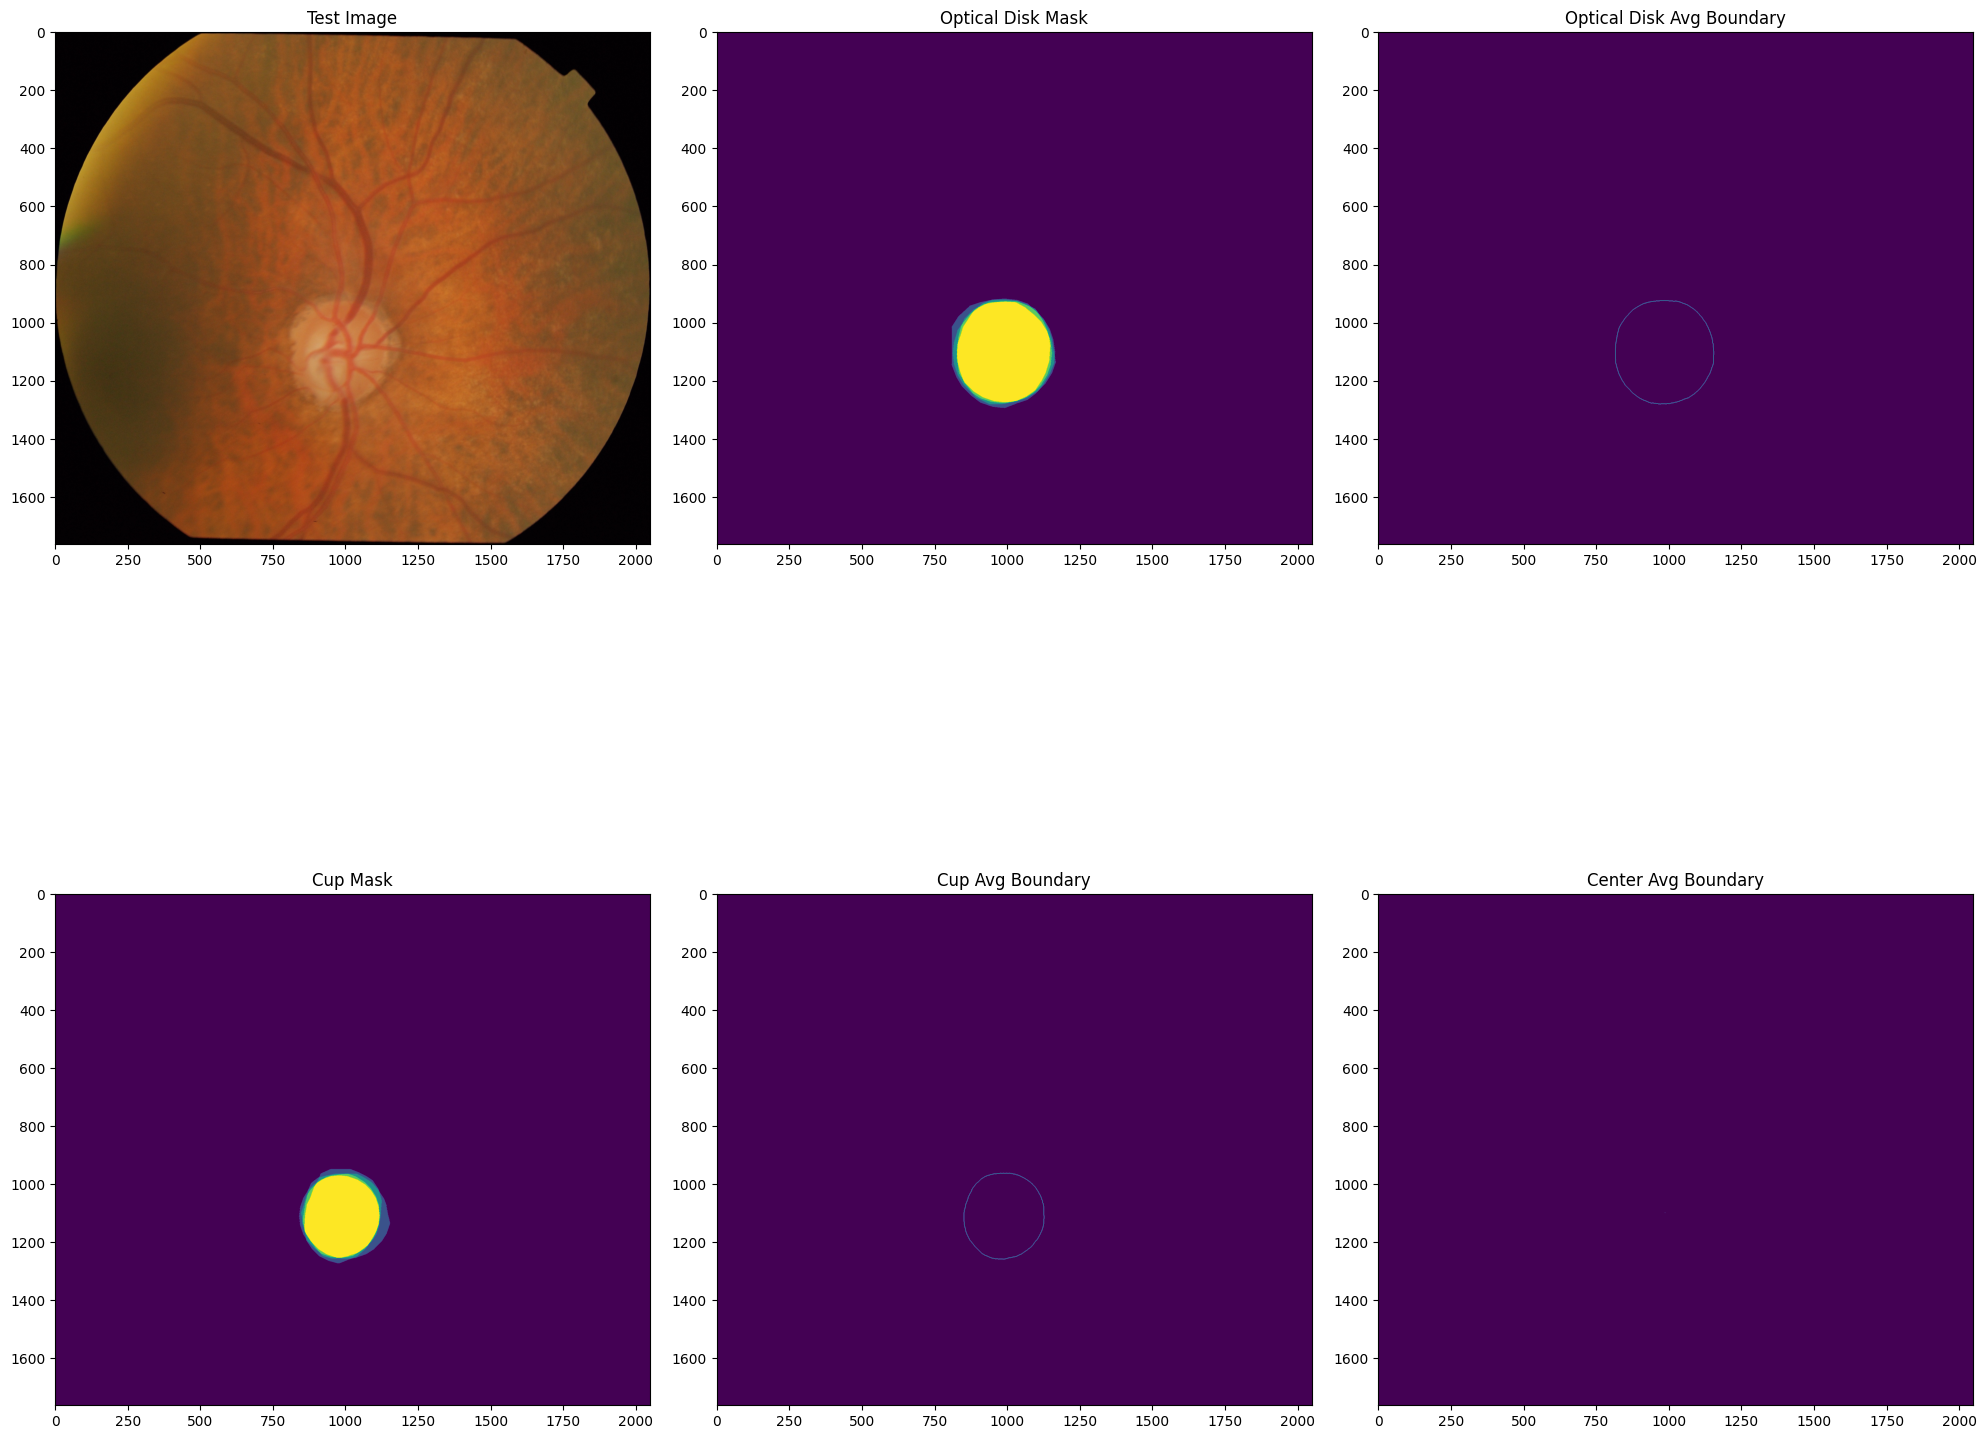

In [31]:
fig, axes = plt.subplots(2, 3, figsize = (20, 20))
axes = axes.flatten()

axes[0].imshow(image)
axes[0].set_title('Test Image')
axes[1].imshow(od)
axes[1].set_title('Optical Disk Mask')
axes[2].imshow(od_mask)
axes[2].set_title('Optical Disk Avg Boundary')
axes[3].imshow(cup)
axes[3].set_title('Cup Mask')
axes[4].imshow(cup_mask)
axes[4].set_title('Cup Avg Boundary')
axes[5].imshow(center_mask)
axes[5].set_title('Center Avg Boundary')
plt.tight_layout()

So the Avg Boundary files give a small ring for a stricter border for the masks. I'm going to ignore them for the time being

In [32]:
train_images = np.concatenate([TRAIN_NORMAL_IMAGES, TRAIN_GLAUCOMA_IMAGES])
test_images = np.concatenate([TEST_NORMAL_IMAGES, TEST_GLAUCOMA_IMAGES])

train_ds_dice = Dataset.from_tensor_slices(train_images)\
    .shuffle(buffer_size = SHUFFLE_BUFFER)\
    .map(lambda x: load_image_with_masks(x, dice = True), num_parallel_calls = AUTOTUNE)\
    .map(lambda image, targets: augment_images(image['image'], targets['od'], targets['cup']))\
    .batch(batch_size = BATCH_SIZE)\
    .prefetch(1)\
    .cache()

train_ds_no_dice = Dataset.from_tensor_slices(train_images)\
    .shuffle(buffer_size = SHUFFLE_BUFFER)\
    .map(lambda x: load_image_with_masks(x, dice = False), num_parallel_calls = AUTOTUNE)\
    .map(lambda image, targets: augment_images(image['image'], targets['od'], targets['cup']))\
    .batch(batch_size = BATCH_SIZE)\
    .prefetch(1)\
    .cache()

test_ds_dice = Dataset.from_tensor_slices(test_images)\
    .map(lambda x: load_image_with_masks(x, dice = True, test = True), num_parallel_calls = AUTOTUNE)\
    .batch(batch_size = BATCH_SIZE)

test_ds_no_dice = Dataset.from_tensor_slices(test_images)\
    .map(lambda x: load_image_with_masks(x, dice = False, test = True), num_parallel_calls = AUTOTUNE)\
    .batch(batch_size = BATCH_SIZE)

In [33]:
train_ds_no_dice_st = Dataset.from_tensor_slices(train_images)\
    .shuffle(buffer_size = SHUFFLE_BUFFER)\
    .map(lambda x: load_image_with_masks(x, dice = False), num_parallel_calls = AUTOTUNE)\
    .map(lambda image, targets: augment_images(image['image'], targets['od'], targets['cup'], single_target = True))\
    .batch(batch_size = BATCH_SIZE)\
    .prefetch(1)\
    .cache()

test_ds_no_dice_st = Dataset.from_tensor_slices(test_images)\
    .map(lambda x: load_image_with_masks(x, dice = False, test = True), num_parallel_calls = AUTOTUNE)\
    .map(lambda image, targets: (image['image'], targets['od']))\
    .batch(batch_size = BATCH_SIZE)

In [34]:
import numpy as np
import math
import torch
from torch import nn
from torch.nn import functional as F
from typing import Union, Type, List, Tuple

from torch.nn.modules.conv import _ConvNd
from torch.nn.modules.dropout import _DropoutNd
from dynamic_network_architectures.building_blocks.helper import convert_conv_op_to_dim

from nnunetv2.utilities.plans_handling.plans_handler import ConfigurationManager, PlansManager
from dynamic_network_architectures.building_blocks.helper import get_matching_instancenorm, convert_dim_to_conv_op
from nnunetv2.utilities.network_initialization import InitWeights_He
from mamba_ssm import Mamba
from dynamic_network_architectures.building_blocks.helper import maybe_convert_scalar_to_list, get_matching_pool_op
from torch.cuda.amp import autocast
from dynamic_network_architectures.building_blocks.residual import BasicBlockD

In [35]:
print(torch.__version__)

2.5.1+cu121


In [36]:
class UpsampleLayer(nn.Module):
    def __init__(
            self,
            conv_op,
            input_channels,
            output_channels,
            pool_op_kernel_size,
            mode='nearest'
        ):
        super().__init__()
        self.conv = conv_op(input_channels, output_channels, kernel_size=1)
        self.pool_op_kernel_size = pool_op_kernel_size
        self.mode = mode
        
    def forward(self, x):
        x = F.interpolate(x, scale_factor=self.pool_op_kernel_size, mode=self.mode)
        x = self.conv(x)
        return x

class MambaLayer(nn.Module):
    def __init__(self, dim, d_state = 16, d_conv = 4, expand = 2):
        super().__init__()
        self.dim = dim
        self.norm = nn.LayerNorm(dim)
        self.mamba = Mamba(
                d_model=dim, # Model dimension d_model
                d_state=d_state,  # SSM state expansion factor
                d_conv=d_conv,    # Local convolution width
                expand=expand,    # Block expansion factor
        )
    
    #@autocast(enabled=False)刪除這行是因為它通常用於AMP，PyTorch自動混合精度運算
    def forward(self, x):
        if x.dtype == torch.float16:
            x = x.type(torch.float32)
        B, C = x.shape[:2]
        assert C == self.dim
        n_tokens = x.shape[2:].numel()
        img_dims = x.shape[2:]
        x_flat = x.reshape(B, C, n_tokens).transpose(-1, -2)
        x_norm = self.norm(x_flat)
        x_mamba = self.mamba(x_norm)
        out = x_mamba.transpose(-1, -2).reshape(B, C, *img_dims)

        return out


class BasicResBlock(nn.Module):
    def __init__(
            self,
            conv_op,
            input_channels,
            output_channels,
            norm_op,
            norm_op_kwargs,
            kernel_size=3,
            padding=1,
            stride=1,
            use_1x1conv=False,
            nonlin=nn.LeakyReLU,
            nonlin_kwargs={'inplace': True}
        ):
        super().__init__()
        
        self.conv1 = conv_op(input_channels, output_channels, kernel_size, stride=stride, padding=padding)
        self.norm1 = norm_op(output_channels, **norm_op_kwargs)
        self.act1 = nonlin(**nonlin_kwargs)
        
        self.conv2 = conv_op(output_channels, output_channels, kernel_size, padding=padding)
        self.norm2 = norm_op(output_channels, **norm_op_kwargs)
        self.act2 = nonlin(**nonlin_kwargs)
        
        if use_1x1conv:
            self.conv3 = conv_op(input_channels, output_channels, kernel_size=1, stride=stride)
        else:
            self.conv3 = None
                  
    def forward(self, x):
        y = self.conv1(x)
        y = self.act1(self.norm1(y))  
        y = self.norm2(self.conv2(y))
        if self.conv3:
            x = self.conv3(x)
        y += x
        return self.act2(y)
    
class UNetResEncoder(nn.Module):
    def __init__(self,
                 input_channels: int,
                 n_stages: int,
                 features_per_stage: Union[int, List[int], Tuple[int, ...]],
                 conv_op: Type[_ConvNd],
                 kernel_sizes: Union[int, List[int], Tuple[int, ...]],
                 strides: Union[int, List[int], Tuple[int, ...], Tuple[Tuple[int, ...], ...]],
                 n_blocks_per_stage: Union[int, List[int], Tuple[int, ...]],
                 conv_bias: bool = False,
                 norm_op: Union[None, Type[nn.Module]] = None,
                 norm_op_kwargs: dict = None,
                 nonlin: Union[None, Type[torch.nn.Module]] = None,
                 nonlin_kwargs: dict = None,
                 return_skips: bool = False,
                 stem_channels: int = None,
                 pool_type: str = 'conv',
                 use_mamba: bool = True #新增-允許是否使用Mamba
                 ):
        super().__init__()
        self.use_mamba = use_mamba #新增紀錄是否使用Mamba
        if isinstance(kernel_sizes, int):
            kernel_sizes = [kernel_sizes] * n_stages
        if isinstance(features_per_stage, int):
            features_per_stage = [features_per_stage] * n_stages
        if isinstance(n_blocks_per_stage, int):
            n_blocks_per_stage = [n_blocks_per_stage] * n_stages
        if isinstance(strides, int):
            strides = [strides] * n_stages

        assert len(
            kernel_sizes) == n_stages, "kernel_sizes must have as many entries as we have resolution stages (n_stages)"
        assert len(
            n_blocks_per_stage) == n_stages, "n_conv_per_stage must have as many entries as we have resolution stages (n_stages)"
        assert len(
            features_per_stage) == n_stages, "features_per_stage must have as many entries as we have resolution stages (n_stages)"
        assert len(strides) == n_stages, "strides must have as many entries as we have resolution stages (n_stages). " \
                                         "Important: first entry is recommended to be 1, else we run strided conv drectly on the input"

        pool_op = get_matching_pool_op(conv_op, pool_type=pool_type) if pool_type != 'conv' else None

        self.conv_pad_sizes = []
        for krnl in kernel_sizes:
            self.conv_pad_sizes.append([i // 2 for i in krnl])

        stem_channels = features_per_stage[0]

        self.stem = nn.Sequential(
            BasicResBlock(
                conv_op = conv_op,
                input_channels = input_channels,
                output_channels = stem_channels,
                norm_op=norm_op,
                norm_op_kwargs=norm_op_kwargs,
                kernel_size=kernel_sizes[0],
                padding=self.conv_pad_sizes[0],
                stride=1,
                nonlin=nonlin,
                nonlin_kwargs=nonlin_kwargs,
                use_1x1conv=True
            ), 
            *[
                BasicBlockD(
                    conv_op = conv_op,
                    input_channels = stem_channels,
                    output_channels = stem_channels,
                    kernel_size = kernel_sizes[0],
                    stride = 1,
                    conv_bias = conv_bias,
                    norm_op = norm_op,
                    norm_op_kwargs = norm_op_kwargs,
                    nonlin = nonlin,
                    nonlin_kwargs = nonlin_kwargs,
                ) for _ in range(n_blocks_per_stage[0] - 1)
            ]
        )


        input_channels = stem_channels

        # now build the network
        stages = []
        for s in range(n_stages):
            stage = nn.Sequential(
                BasicResBlock(
                    conv_op = conv_op,
                    norm_op = norm_op,
                    norm_op_kwargs = norm_op_kwargs,
                    input_channels = input_channels,
                    output_channels = features_per_stage[s],
                    kernel_size = kernel_sizes[s],
                    padding=self.conv_pad_sizes[s],
                    stride=strides[s],
                    use_1x1conv=True,
                    nonlin = nonlin,
                    nonlin_kwargs = nonlin_kwargs
                ),
                *[
                    BasicBlockD(
                        conv_op = conv_op,
                        input_channels = features_per_stage[s],
                        output_channels = features_per_stage[s],
                        kernel_size = kernel_sizes[s],
                        stride = 1,
                        conv_bias = conv_bias,
                        norm_op = norm_op,
                        norm_op_kwargs = norm_op_kwargs,
                        nonlin = nonlin,
                        nonlin_kwargs = nonlin_kwargs,
                    ) for _ in range(n_blocks_per_stage[s] - 1)
                ]
            )

            stages.append(stage)
            input_channels = features_per_stage[s]

        self.stages = nn.Sequential(*stages)
        self.output_channels = features_per_stage
        self.strides = [maybe_convert_scalar_to_list(conv_op, i) for i in strides]
        self.return_skips = return_skips

        #新增Encoder最後一層加入MambaLayer
        if self.use_mamba:
            self.mamba_layer = MambaLayer(dim = features_per_stage[-1])

        self.conv_op = conv_op
        self.norm_op = norm_op
        self.norm_op_kwargs = norm_op_kwargs
        self.nonlin = nonlin
        self.nonlin_kwargs = nonlin_kwargs
        #self.dropout_op = dropout_op
        #self.dropout_op_kwargs = dropout_op_kwargs
        self.conv_bias = conv_bias
        self.kernel_sizes = kernel_sizes

    def forward(self, x):
        if self.stem is not None:
            x = self.stem(x)
        ret = []
        for s in self.stages:
            x = s(x)
            ret.append(x)
        #新增，如果使用Mamba，會將Encoder最後的輸出送到MambaLayer
        if self.use_mamba:
            ret[-1] = self.mamba_layer(ret[-1])
        
        if self.return_skips:
            return ret
        else:
            return ret[-1]
    
    def compute_conv_feature_map_size(self, input_size):
        if self.stem is not None:
            output = self.stem.compute_conv_feature_map_size(input_size)
        else:
            output = np.int64(0)

        for s in range(len(self.stages)):
            output += self.stages[s].compute_conv_feature_map_size(input_size)
            input_size = [i // j for i, j in zip(input_size, self.strides[s])]

        return output


class UNetResDecoder(nn.Module):
    def __init__(self,
                 encoder,
                 num_classes,
                 n_conv_per_stage: Union[int, Tuple[int, ...], List[int]],
                 deep_supervision, nonlin_first: bool = False):

        super().__init__()
        self.deep_supervision = deep_supervision
        self.encoder = encoder
        self.num_classes = num_classes
        n_stages_encoder = len(encoder.output_channels)
        if isinstance(n_conv_per_stage, int):
            n_conv_per_stage = [n_conv_per_stage] * (n_stages_encoder - 1)
        assert len(n_conv_per_stage) == n_stages_encoder - 1, "n_conv_per_stage must have as many entries as we have " \
                                                          "resolution stages - 1 (n_stages in encoder - 1), " \
                                                          "here: %d" % n_stages_encoder

        stages = []
        upsample_layers = []

        seg_layers = []
        for s in range(1, n_stages_encoder):
            input_features_below = encoder.output_channels[-s]
            input_features_skip = encoder.output_channels[-(s + 1)]
            stride_for_upsampling = encoder.strides[-s]
            upsample_layers.append(UpsampleLayer(
                conv_op = encoder.conv_op,
                input_channels = input_features_below,
                output_channels = input_features_skip,
                pool_op_kernel_size = stride_for_upsampling,
                mode='nearest'
            ))

            stages.append(nn.Sequential(
                BasicResBlock(
                    conv_op = encoder.conv_op,
                    norm_op = encoder.norm_op,
                    norm_op_kwargs = encoder.norm_op_kwargs,
                    nonlin = encoder.nonlin,
                    nonlin_kwargs = encoder.nonlin_kwargs,
                    input_channels = 2 * input_features_skip if s < n_stages_encoder - 1 else input_features_skip,
                    output_channels = input_features_skip,
                    kernel_size = encoder.kernel_sizes[-(s + 1)],
                    padding=encoder.conv_pad_sizes[-(s + 1)],
                    stride=1,
                    use_1x1conv=True
                ),
                *[
                    BasicBlockD(
                        conv_op = encoder.conv_op,
                        input_channels = input_features_skip,
                        output_channels = input_features_skip,
                        kernel_size = encoder.kernel_sizes[-(s + 1)],
                        stride = 1,
                        conv_bias = encoder.conv_bias,
                        norm_op = encoder.norm_op,
                        norm_op_kwargs = encoder.norm_op_kwargs,
                        nonlin = encoder.nonlin,
                        nonlin_kwargs = encoder.nonlin_kwargs,
                    ) for _ in range(n_conv_per_stage[s-1] - 1)
                ]
            ))
            seg_layers.append(encoder.conv_op(input_features_skip, num_classes, 1, 1, 0, bias=True))

        self.stages = nn.ModuleList(stages)
        self.upsample_layers = nn.ModuleList(upsample_layers)
        self.seg_layers = nn.ModuleList(seg_layers)

    def forward(self, skips):
        lres_input = skips[-1]
        seg_outputs = []
        for s in range(len(self.stages)):
            x = self.upsample_layers[s](lres_input)
            if s < (len(self.stages) - 1):
                x = torch.cat((x, skips[-(s+2)]), 1)
            x = self.stages[s](x)
            if self.deep_supervision:
                seg_outputs.append(self.seg_layers[s](x))
            elif s == (len(self.stages) - 1):
                seg_outputs.append(self.seg_layers[-1](x))
            lres_input = x

        seg_outputs = seg_outputs[::-1]

        if not self.deep_supervision:
            r = seg_outputs[0]
        else:
            r = seg_outputs
        return r

    def compute_conv_feature_map_size(self, input_size):
        skip_sizes = []
        for s in range(len(self.encoder.strides) - 1):
            skip_sizes.append([i // j for i, j in zip(input_size, self.encoder.strides[s])])
            input_size = skip_sizes[-1]

        assert len(skip_sizes) == len(self.stages)

        output = np.int64(0)
        for s in range(len(self.stages)):
            output += self.stages[s].compute_conv_feature_map_size(skip_sizes[-(s+1)])
            output += np.prod([self.encoder.output_channels[-(s+2)], *skip_sizes[-(s+1)]], dtype=np.int64)
            if self.deep_supervision or (s == (len(self.stages) - 1)):
                output += np.prod([self.num_classes, *skip_sizes[-(s+1)]], dtype=np.int64)
        return output


class UMambaBot(nn.Module):
    def __init__(self,
                 input_channels: int,
                 n_stages: int,
                 features_per_stage: Union[int, List[int], Tuple[int, ...]],
                 conv_op: Type[nn.Conv2d],
                 kernel_sizes: Union[int, List[int], Tuple[int, ...]],
                 strides: Union[int, List[int], Tuple[int, ...]],
                 n_conv_per_stage: Union[int, List[int], Tuple[int, ...]],
                 num_classes: int,
                 n_conv_per_stage_decoder: Union[int, Tuple[int, ...], List[int]],
                 conv_bias: bool = False,
                 norm_op: Union[None, Type[nn.Module]] = None,
                 norm_op_kwargs: dict = None,
                 dropout_op: Union[None, Type[nn.Module]] = None,
                 dropout_op_kwargs: dict = None,
                 nonlin: Union[None, Type[torch.nn.Module]] = None,
                 nonlin_kwargs: dict = None,
                 deep_supervision: bool = False,
                 stem_channels: int = None
                 ):
        super().__init__()

        self.encoder = UNetResEncoder(
            input_channels,
            n_stages,
            features_per_stage,
            conv_op,
            kernel_sizes,
            strides,
            n_conv_per_stage,
            conv_bias,
            norm_op,
            norm_op_kwargs,
            nonlin,
            nonlin_kwargs,
            return_skips=True,
            stem_channels=stem_channels,
            use_mamba=True  # 啟用 Mamba
        )

        # 初始化 MSAA
        self.msaa1 = MSAA(in_channels=features_per_stage[0] * 3, out_channels=features_per_stage[0])
        self.msaa2 = MSAA(in_channels=features_per_stage[1] * 3, out_channels=features_per_stage[1])
        self.msaa3 = MSAA(in_channels=features_per_stage[2] * 3, out_channels=features_per_stage[2])
        self.msaa4 = MSAA(in_channels=features_per_stage[3] * 3, out_channels=features_per_stage[3])

        self.decoder = UNetResDecoder(self.encoder, num_classes, n_conv_per_stage_decoder, deep_supervision)

    def forward(self, x):
        skips = self.encoder(x)

        # 確保 Encoder 回傳了 4 層特徵
        if len(skips) < 4:
            raise ValueError(f"Expected 4 feature maps from encoder, but got {len(skips)}")
        
        x1, x2, x3, x4 = skips[:4]

        # 上下採樣以對齊特徵圖維度
        x1_2 = F.interpolate(x1, scale_factor=0.5, mode="bilinear", align_corners=True)
        x3_2 = F.interpolate(x3, scale_factor=2.0, mode="bilinear", align_corners=True)
        x4_2 = F.interpolate(x4, scale_factor=4.0, mode="bilinear", align_corners=True)

        x1_3 = F.interpolate(x1, scale_factor=0.25, mode="bilinear", align_corners=True)
        x2_3 = F.interpolate(x2, scale_factor=0.5, mode="bilinear", align_corners=True)
        x4_3 = F.interpolate(x4, scale_factor=2.0, mode="bilinear", align_corners=True)

        x1_4 = F.interpolate(x1, scale_factor=0.125, mode="bilinear", align_corners=True)
        x2_4 = F.interpolate(x2, scale_factor=0.25, mode="bilinear", align_corners=True)
        x3_4 = F.interpolate(x3, scale_factor=0.5, mode="bilinear", align_corners=True)

        # MSAA 處理
        x1 = self.msaa1(x1, x1_2, x1_3)
        x2 = self.msaa2(x2, x2_3, x2_4)
        x3 = self.msaa3(x3, x3_2, x3_4)
        x4 = self.msaa4(x4, x4_2, x4_3)

        # 更新 skips 以包含 MSAA 處理過的特徵
        skips = [x1, x2, x3, x4]

        # 傳入 Decoder
        return self.decoder(skips)


In [37]:
import mamba_ssm
print(dir(mamba_ssm))  # 列出 `mamba_ssm` 可用的物件

['Mamba', 'Mamba2', 'MambaLMHeadModel', '__builtins__', '__cached__', '__doc__', '__file__', '__loader__', '__name__', '__package__', '__path__', '__spec__', '__version__', 'distributed', 'mamba_inner_fn', 'models', 'modules', 'ops', 'selective_scan_fn', 'utils']


In [38]:
import tensorflow as tf
import torch
from tensorflow.keras.layers import Lambda, Conv2D, BatchNormalization, SpatialDropout2D, MaxPool2D
from mamba_ssm import Mamba

def apply_mamba(x):
    #直接轉換為 PyTorch Tensor，避免使用 NumPy
    x_torch = torch.tensor(x, dtype=torch.float32)  # 轉為 PyTorch Tensor
    x_torch = Mamba(d_model=x.shape[-1])(x_torch)  # 使用 Mamba

    #轉回 TensorFlow Tensor
    return tf.convert_to_tensor(x_torch.detach().numpy())

def conv_block(inp, filters, kernels, strides, rates):
    activation = 'relu'
    x = inp
    skips = []

    for i, (f, kernel, stride, rate) in enumerate(zip(filters, kernels, strides, rates)):
        print(f"Conv Block | Layer {i} | Before Conv | x.shape = {x.shape}")

        #改成所有層都收集跳層
        skips.append(x)

        if stride == 2:
            x = MaxPool2D()(x)

        x = Conv2D(filters=f, kernel_size=kernel, strides=1, activation=activation, padding='same')(x)
        x = BatchNormalization()(x)
        x = SpatialDropout2D(rate=rate)(x)

        print(f"Conv Block | Layer {i} | After Conv  | x.shape = {x.shape}")

    print(f"Conv Block | Collected {len(skips)} skip connections")  #確保收集到 4個 skip
    return skips, x


In [39]:
from tensorflow.keras.layers import Input, Conv2D
from tensorflow.keras.models import Model

def res_unet(conv_filters, conv_kernels, conv_strides, conv_rates, 
             up_filters, up_kernels, up_rates, up_block): 

    '''
    Builds the U-Net structure
    The output is two heads:
    - One for the Optical Disk (od)
    - Another for the Cup (cup)
    '''
    
    inp = Input(shape=(224, 224, 3), name='image')  #輸入大小
    x = inp

    # **編碼 (Encoder) 部分**
    skips, x = conv_block(x, conv_filters, conv_kernels, conv_strides, conv_rates)

    print(f"Res UNet | skips collected (before reverse) = {len(skips)}")
    skips = skips[::-1]  # 翻轉，使最近的跳層在最前面
    print(f"Res UNet | skips collected (after reverse) = {len(skips)}")

    #確保 `skips` 在 `od` 和 `cup` 不被重複使用
    od_skips = skips[:]  #深拷貝
    cup_skips = skips[:]

    # **解碼 (Decoder) 部分**
    x_od = up_block(x, od_skips, up_filters, up_kernels, up_rates)
    od = Conv2D(filters=1, kernel_size=1, strides=1, padding='same', activation='sigmoid', name='od')(x_od)

    x_cup = up_block(x, cup_skips, up_filters, up_kernels, up_rates)
    cup = Conv2D(filters=1, kernel_size=1, strides=1, padding='same', activation='sigmoid', name='cup')(x_cup)

    return Model(inputs=inp, outputs={'od': od, 'cup': cup})  #以字典形式輸出

In [40]:
from tensorflow.keras.layers import UpSampling2D, Concatenate

def upsampling_block_mod1(inp, skips, filters, kernels, rates):
    '''
    Creates a block for upsampling
    Doubles the image dimensions
    And adds the skip connection
    '''   
    activation = 'relu'
    x = inp

    print(f"Upsampling Block | skips layers = {len(skips)}")  #確保 skips 真的有 4 層

    for i, (f, kernel, skip, rate) in enumerate(zip(filters, kernels, skips, rates)):
        print(f"Upsampling Block | Layer {i} | Before Resize | x.shape = {x.shape}, skip.shape = {skip.shape}")

        #進行上採樣，使 x 的大小與 skip 匹配
        x = UpSampling2D(size=(2,2))(x)
        x = Conv2D(filters=f, kernel_size=kernel, strides=1, activation=activation, padding='same')(x)

        print(f"Upsampling Block | Layer {i} | After Resize | x.shape = {x.shape}, skip.shape = {skip.shape}")

        #確保 x 和 skip 形狀一致
        x = Concatenate()([x, skip])  # **這裡如果大小不同，會報錯**
        x = BatchNormalization()(x)
        x = SpatialDropout2D(rate=rate)(x)

    return x

In [41]:
def res_unet_st(conv_filters, conv_kernels, conv_strides, conv_rates, up_filters, up_kernels, up_rates):
    '''
    Builds the u-net structure
    The output is two heads
    One for the Optical Disk
    And another for the cup
    '''
    inp = Input(shape = (*IMAGE_SIZE, 3), name = 'image')
    x = inp
    
    skips, x = conv_block(x, conv_filters, conv_kernels, conv_strides, conv_rates)
    
    skips = skips[::-1]
    
    od = upsampling_block(x, skips, up_filters, up_kernels, up_rates)
    od = Conv2D(filters = 1, kernel_size = 1, strides = 1, padding = 'same', activation = 'sigmoid', name = 'od')(od)
           
    return Model(inputs = inp, outputs = od)

In [42]:
def dice(y_true, y_pred):
    '''
    Dice Loss, similar to
    Intersection over Union
    '''
    epsilon = 1e-6
    # 攤成 (batch, H*W) 以支援所有形狀
    y_true_f = tf.keras.backend.flatten(y_true)
    y_pred_f = tf.keras.backend.flatten(y_pred)
    
    numerator = 2 * tf.reduce_sum(y_true_f * y_pred_f, axis = -1)
    denominator = tf.reduce_sum(y_true_f + y_pred_f, axis = -1)
    dice = tf.reduce_mean((numerator + epsilon)/(denominator + epsilon))
    return 1 - tf.reduce_mean(dice)


In [43]:
conv_filters = [8, 16, 32, 64]
conv_kernels = [3, 3, 3, 3]
conv_strides = [2, 2, 2, 2]
conv_rates = [0.8, 0.8, 0.8, 0.8]

upsampling_filters = [32, 16, 8, 8]
upsampling_kernels = [3, 3, 3, 3]
upsampling_rates = [2, 2, 2, 2]

In [44]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,         # 允許 10 個 epoch 無改善
    restore_best_weights=True  # 回復最佳權重
)

In [45]:
dropout_rates = [0.5, 0.5, 0.5, 0.5]  #要在 0~1 之間

mod1 = res_unet(conv_filters, conv_kernels, conv_strides, conv_rates, 
                upsampling_filters, upsampling_kernels, dropout_rates,upsampling_block_mod1) 
mod1.compile(
    optimizer='Adam', 
    loss={'od': dice, 'cup': dice},  
    metrics={'od': ['accuracy'], 'cup': ['accuracy']}  #為每個輸出設定 metrics
)

hist1 = mod1.fit(train_ds_dice, validation_data=test_ds_dice, 
                 callbacks=[early_stopping], epochs=200)

Conv Block | Layer 0 | Before Conv | x.shape = (None, 224, 224, 3)
Conv Block | Layer 0 | After Conv  | x.shape = (None, 112, 112, 8)
Conv Block | Layer 1 | Before Conv | x.shape = (None, 112, 112, 8)
Conv Block | Layer 1 | After Conv  | x.shape = (None, 56, 56, 16)
Conv Block | Layer 2 | Before Conv | x.shape = (None, 56, 56, 16)
Conv Block | Layer 2 | After Conv  | x.shape = (None, 28, 28, 32)
Conv Block | Layer 3 | Before Conv | x.shape = (None, 28, 28, 32)
Conv Block | Layer 3 | After Conv  | x.shape = (None, 14, 14, 64)
Conv Block | Collected 4 skip connections
Res UNet | skips collected (before reverse) = 4
Res UNet | skips collected (after reverse) = 4
Upsampling Block | skips layers = 4
Upsampling Block | Layer 0 | Before Resize | x.shape = (None, 14, 14, 64), skip.shape = (None, 28, 28, 32)
Upsampling Block | Layer 0 | After Resize | x.shape = (None, 28, 28, 32), skip.shape = (None, 28, 28, 32)
Upsampling Block | Layer 1 | Before Resize | x.shape = (None, 28, 28, 64), skip.sha

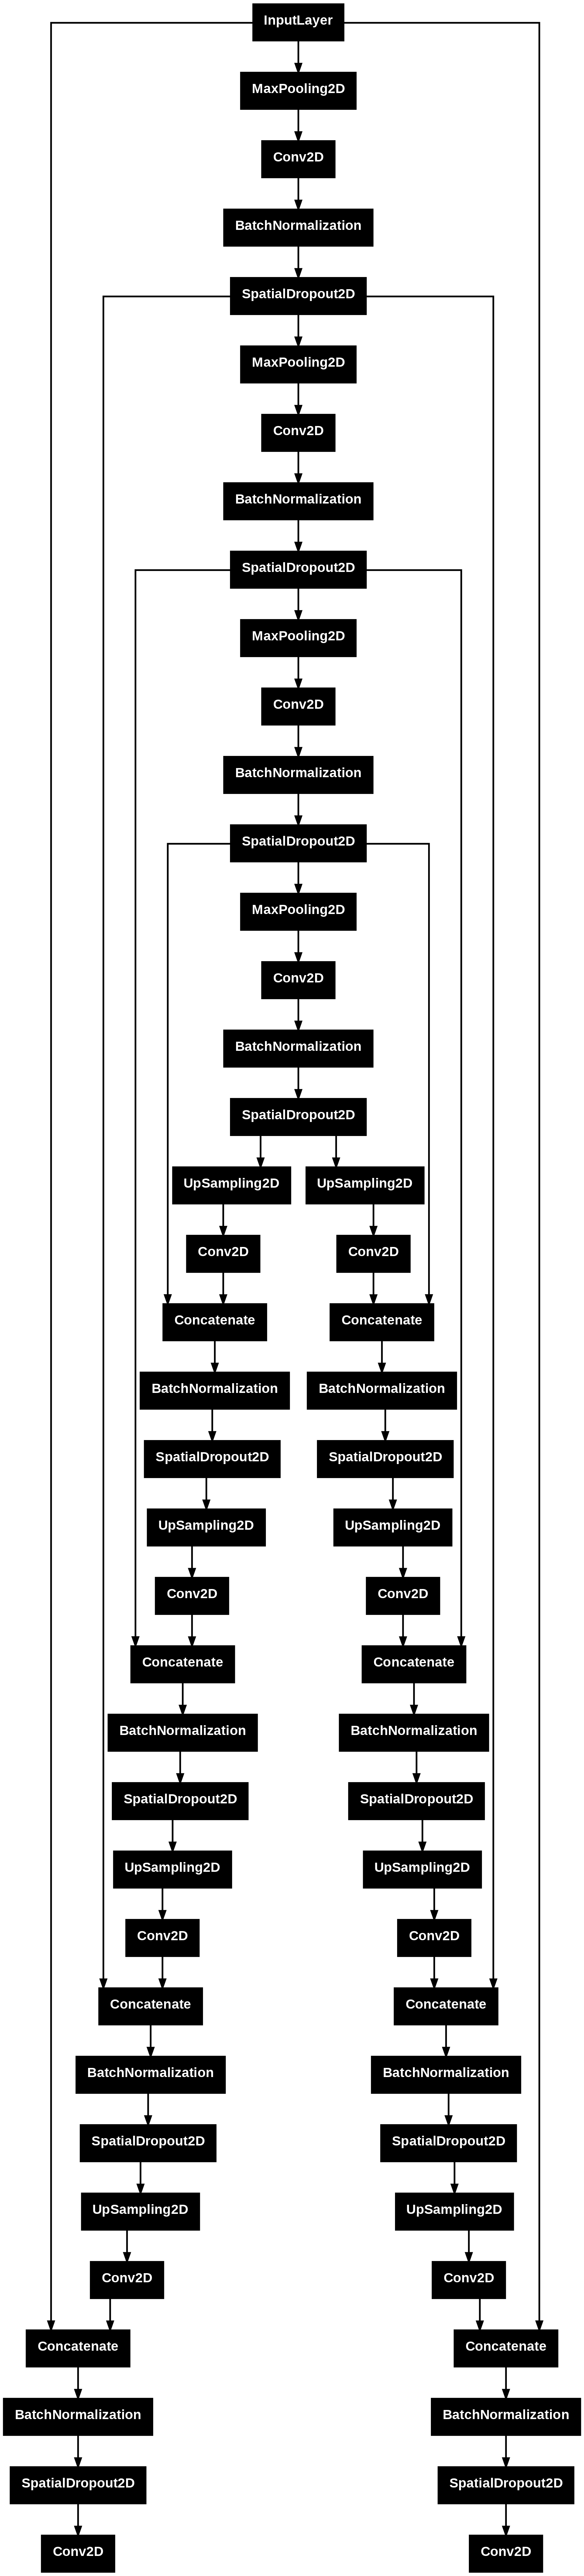

In [46]:
plot_model(mod1)

In [47]:
hist1 = mod1.fit(train_ds_dice, validation_data = test_ds_dice, callbacks = [early_stopping], epochs = 200)

Epoch 1/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - cup_accuracy: 0.7443 - cup_loss: 0.9492 - loss: 1.8598 - od_accuracy: 0.7360 - od_loss: 0.9107 - val_cup_accuracy: 0.9867 - val_cup_loss: 0.9556 - val_loss: 1.8630 - val_od_accuracy: 0.9687 - val_od_loss: 0.9187
Epoch 2/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - cup_accuracy: 0.7318 - cup_loss: 0.9463 - loss: 1.8385 - od_accuracy: 0.7561 - od_loss: 0.8922 - val_cup_accuracy: 0.9853 - val_cup_loss: 0.9557 - val_loss: 1.8663 - val_od_accuracy: 0.9683 - val_od_loss: 0.9214
Epoch 3/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - cup_accuracy: 0.7349 - cup_loss: 0.9484 - loss: 1.8421 - od_accuracy: 0.7714 - od_loss: 0.8938 - val_cup_accuracy: 0.9846 - val_cup_loss: 0.9557 - val_loss: 1.8696 - val_od_accuracy: 0.9683 - val_od_loss: 0.9245
Epoch 4/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - cup_accuracy: 0.7256 - cup_loss: 0.9471 - loss: 1.8556 - od_accuracy: 0.7404 - od_loss: 0.9084 - val_cup_accuracy: 0.9840 - val_cup_loss: 0.9558 - val_loss: 1.8718 

In [48]:
from tensorflow.keras.layers import UpSampling2D, Concatenate, Lambda, SpatialDropout2D
import tensorflow.keras.backend as K

def upsampling_block_mod2(inp, skips, filters, kernels, rates):
    '''
    Upsampling block for mod2 (fixed)
    Ensures x and skip have matching shapes
    '''
    activation = 'relu'
    x = inp

    print(f"Upsampling Block | skips layers = {len(skips)}")  # 確保 skips 是 4 層

    for i, (f, kernel, skip, rate) in enumerate(zip(filters, kernels, skips, rates)):
        print(f"Upsampling Block | Layer {i} | Before Resize | x.shape = {x.shape}, skip.shape = {skip.shape}")

        #進行上採樣
        x = UpSampling2D(size=(2,2))(x)
        x = Conv2D(filters=f, kernel_size=kernel, strides=1, activation=activation, padding='same')(x)

        #確保 Concatenate 形狀匹配
        x = Lambda(lambda x: tf.image.resize(x, size=(K.int_shape(skip)[1], K.int_shape(skip)[2])))(x)
        print(f"Upsampling Block | Layer {i} | After Resize | x.shape = {x.shape}, skip.shape = {skip.shape}")

        x = Concatenate()([x, skip])
        x = BatchNormalization()(x)

        rate = min(max(rate, 0.0), 1.0)  #確保`rate`在 0~1 之間
        x = SpatialDropout2D(rate=rate)(x)

    return x

In [49]:
conv_filters = [8, 16, 32, 64]
conv_kernels = [3, 3, 3, 3]
conv_strides = [2, 2, 2, 2]
conv_rates = [0.8, 0.8, 0.8, 0.8]

upsampling_filters = [32, 16, 8, 8]
upsampling_kernels = [3, 3, 3, 3]
upsampling_rates = [0.2, 0.2, 0.2, 0.2]

In [50]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,         # 允許 10 個 epoch 無改善
    restore_best_weights=True  # 回復最佳權重
)

In [51]:
dropout_rates = [0.5, 0.5, 0.5, 0.5]

mod2 = res_unet(conv_filters, conv_kernels, conv_strides, conv_rates, 
                upsampling_filters, upsampling_kernels, dropout_rates,upsampling_block_mod1)
mod2.compile(
    optimizer='Adam', 
    loss={'od': 'dice', 'cup': 'dice'},  
    metrics={'od': ['accuracy'], 'cup': ['accuracy']}
)

hist2 = mod2.fit(train_ds_no_dice, validation_data=test_ds_no_dice, 
                 callbacks=[early_stopping], epochs=200)

Conv Block | Layer 0 | Before Conv | x.shape = (None, 224, 224, 3)
Conv Block | Layer 0 | After Conv  | x.shape = (None, 112, 112, 8)
Conv Block | Layer 1 | Before Conv | x.shape = (None, 112, 112, 8)
Conv Block | Layer 1 | After Conv  | x.shape = (None, 56, 56, 16)
Conv Block | Layer 2 | Before Conv | x.shape = (None, 56, 56, 16)
Conv Block | Layer 2 | After Conv  | x.shape = (None, 28, 28, 32)
Conv Block | Layer 3 | Before Conv | x.shape = (None, 28, 28, 32)
Conv Block | Layer 3 | After Conv  | x.shape = (None, 14, 14, 64)
Conv Block | Collected 4 skip connections
Res UNet | skips collected (before reverse) = 4
Res UNet | skips collected (after reverse) = 4
Upsampling Block | skips layers = 4
Upsampling Block | Layer 0 | Before Resize | x.shape = (None, 14, 14, 64), skip.shape = (None, 28, 28, 32)
Upsampling Block | Layer 0 | After Resize | x.shape = (None, 28, 28, 32), skip.shape = (None, 28, 28, 32)
Upsampling Block | Layer 1 | Before Resize | x.shape = (None, 28, 28, 64), skip.sha

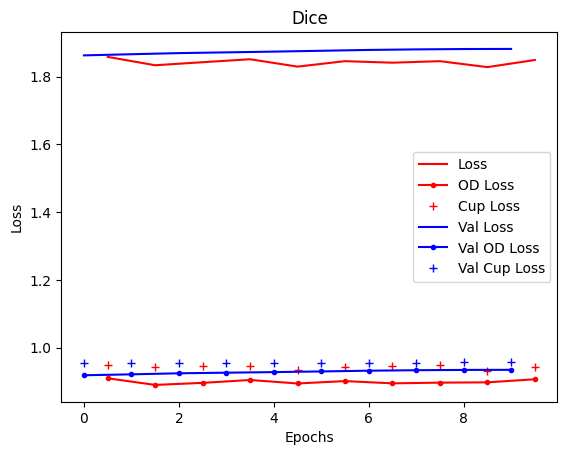

In [52]:
def plot_loss(epochs, hist, loss):
    '''
    Shows the loss metrics
    Uses a more fair comparison
    Between Val and Train
    By shifting the train loss
    an epoch later
    (Train loss is also hurt
    by the dropout layers)
    '''
    plt.plot(epochs + .5, hist.history['loss'], 'r', label = 'Loss')
    plt.plot(epochs + .5, hist.history['od_loss'], 'r.-', label = 'OD Loss')
    plt.plot(epochs + .5, hist.history['cup_loss'], 'r+', label = 'Cup Loss')
    plt.plot(epochs, hist.history['val_loss'], 'b', label = 'Val Loss')
    plt.plot(epochs, hist.history['val_od_loss'], 'b.-', label = 'Val OD Loss')
    plt.plot(epochs, hist.history['val_cup_loss'], 'b+', label = 'Val Cup Loss')
    plt.legend()
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title(loss)


epochs1 = np.arange(0, len(hist1.history['loss']))
plot_loss(epochs1, hist1, 'Dice')

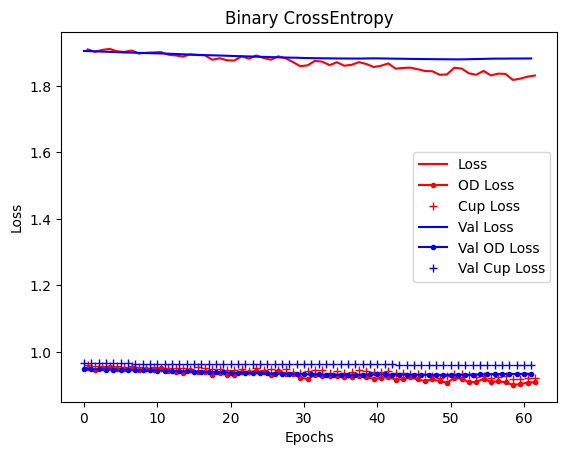

In [53]:
epochs2 = np.arange(0, len(hist2.history['loss']))
plot_loss(epochs2, hist2, 'Binary CrossEntropy')

In [54]:
to_predict = Dataset.from_tensor_slices(test_images)\
    .map(lambda x: load_image_with_masks(x, dice = True, test = True), num_parallel_calls = AUTOTUNE)\
    .map(lambda image, targets: image['image'])\
    .batch(batch_size = BATCH_SIZE)


predict1 = mod1.predict(to_predict)
predict2 = mod2.predict(to_predict)

3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 596ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 772ms/step


In [55]:
# 取出第一張圖片的預測
od_first = predict1["od"][0]
cup_first = predict1["cup"][0]

print("First OD Prediction shape:", od_first.shape)
print("First Cup Prediction shape:", cup_first.shape)

First OD Prediction shape: (224, 224, 1)
First Cup Prediction shape: (224, 224, 1)


In [56]:
'''
def plt_preds(ds, preds, super_title, binarizer_threshold = 0.5):
    
    ds = next(iter(ds))
    image, targets = ds
    image = image['image']
    od = targets['od']
    cup = targets['cup']
    preds = next(iter(preds))
    rows = 5
    cols = 7
    fig, axes = plt.subplots(rows, cols, figsize = (20, 20))
    axes = axes.flatten()
    for i in range(rows):
        axes[cols * i].imshow(image[i])
        axes[cols * i].set_title('Original Image')
        axes[cols * i + 1].imshow(od[i])
        axes[cols * i + 1].set_title('Original OD Mask')
        axes[cols * i + 2].imshow(cup[i])
        axes[cols * i + 2].set_title('Original Cup Mask')
        axes[cols * i + 3].imshow(preds[i])
        axes[cols * i + 3].set_title('Predicted OD Mask')
        axes[cols * i + 4].imshow(np.where(preds[i] > binarizer_threshold, 1, 0))
        axes[cols * i + 4].set_title('Binarized OD Mask')
        axes[cols * i + 5].imshow(preds[26 + i - 1])
        axes[cols * i + 5].set_title('Predicted Cup Mask')
        axes[cols * i + 6].imshow(np.where(preds[26 + i] >= binarizer_threshold, 1, 0))
        axes[cols * i + 6].set_title('Binarized Cup Mask')
    plt.suptitle(super_title)
    '''

"\ndef plt_preds(ds, preds, super_title, binarizer_threshold = 0.5):\n    \n    ds = next(iter(ds))\n    image, targets = ds\n    image = image['image']\n    od = targets['od']\n    cup = targets['cup']\n    preds = next(iter(preds))\n    rows = 5\n    cols = 7\n    fig, axes = plt.subplots(rows, cols, figsize = (20, 20))\n    axes = axes.flatten()\n    for i in range(rows):\n        axes[cols * i].imshow(image[i])\n        axes[cols * i].set_title('Original Image')\n        axes[cols * i + 1].imshow(od[i])\n        axes[cols * i + 1].set_title('Original OD Mask')\n        axes[cols * i + 2].imshow(cup[i])\n        axes[cols * i + 2].set_title('Original Cup Mask')\n        axes[cols * i + 3].imshow(preds[i])\n        axes[cols * i + 3].set_title('Predicted OD Mask')\n        axes[cols * i + 4].imshow(np.where(preds[i] > binarizer_threshold, 1, 0))\n        axes[cols * i + 4].set_title('Binarized OD Mask')\n        axes[cols * i + 5].imshow(preds[26 + i - 1])\n        axes[cols * i + 5]

In [57]:
import numpy as np
import matplotlib.pyplot as plt

def plt_preds(ds, preds, super_title, binarizer_threshold=0.5):
    ds = next(iter(ds))
    image, targets = ds
    image = image['image']
    od = targets['od']
    cup = targets['cup']

    # **修正點：提取 'od' 預測數據**
    if isinstance(preds, dict):
        preds = preds.get('od', None)  # 確保提取到正確數據
        if preds is None:
            raise ValueError("preds['od'] is missing!")

    # **確保轉為 float32**
    preds = np.array(preds, dtype=np.float32)

    # **確保所有數據都是 NumPy 陣列**
    image = image.numpy() if hasattr(image, "numpy") else np.array(image)
    od = od.numpy() if hasattr(od, "numpy") else np.array(od)
    cup = cup.numpy() if hasattr(cup, "numpy") else np.array(cup)

    rows = min(5, image.shape[0])  # **避免超過可視化範圍**
    cols = 7
    fig, axes = plt.subplots(rows, cols, figsize=(20, 20))
    axes = axes.flatten()

    for i in range(rows):
        axes[cols * i].imshow(image[i])
        axes[cols * i].set_title('Original Image')

        axes[cols * i + 1].imshow(od[i])
        axes[cols * i + 1].set_title('Original OD Mask')

        axes[cols * i + 2].imshow(cup[i])
        axes[cols * i + 2].set_title('Original Cup Mask')

        axes[cols * i + 3].imshow(preds[i])
        axes[cols * i + 3].set_title('Predicted OD Mask')

        axes[cols * i + 4].imshow(np.where(preds[i] > binarizer_threshold, 1, 0))
        axes[cols * i + 4].set_title('Binarized OD Mask')

        if len(preds) > 26 + i:
            axes[cols * i + 5].imshow(preds[26 + i - 1])
            axes[cols * i + 5].set_title('Predicted Cup Mask')

            axes[cols * i + 6].imshow(np.where(preds[26 + i] >= binarizer_threshold, 1, 0))
            axes[cols * i + 6].set_title('Binarized Cup Mask')

    plt.suptitle(super_title)
    plt.tight_layout()
    plt.show()


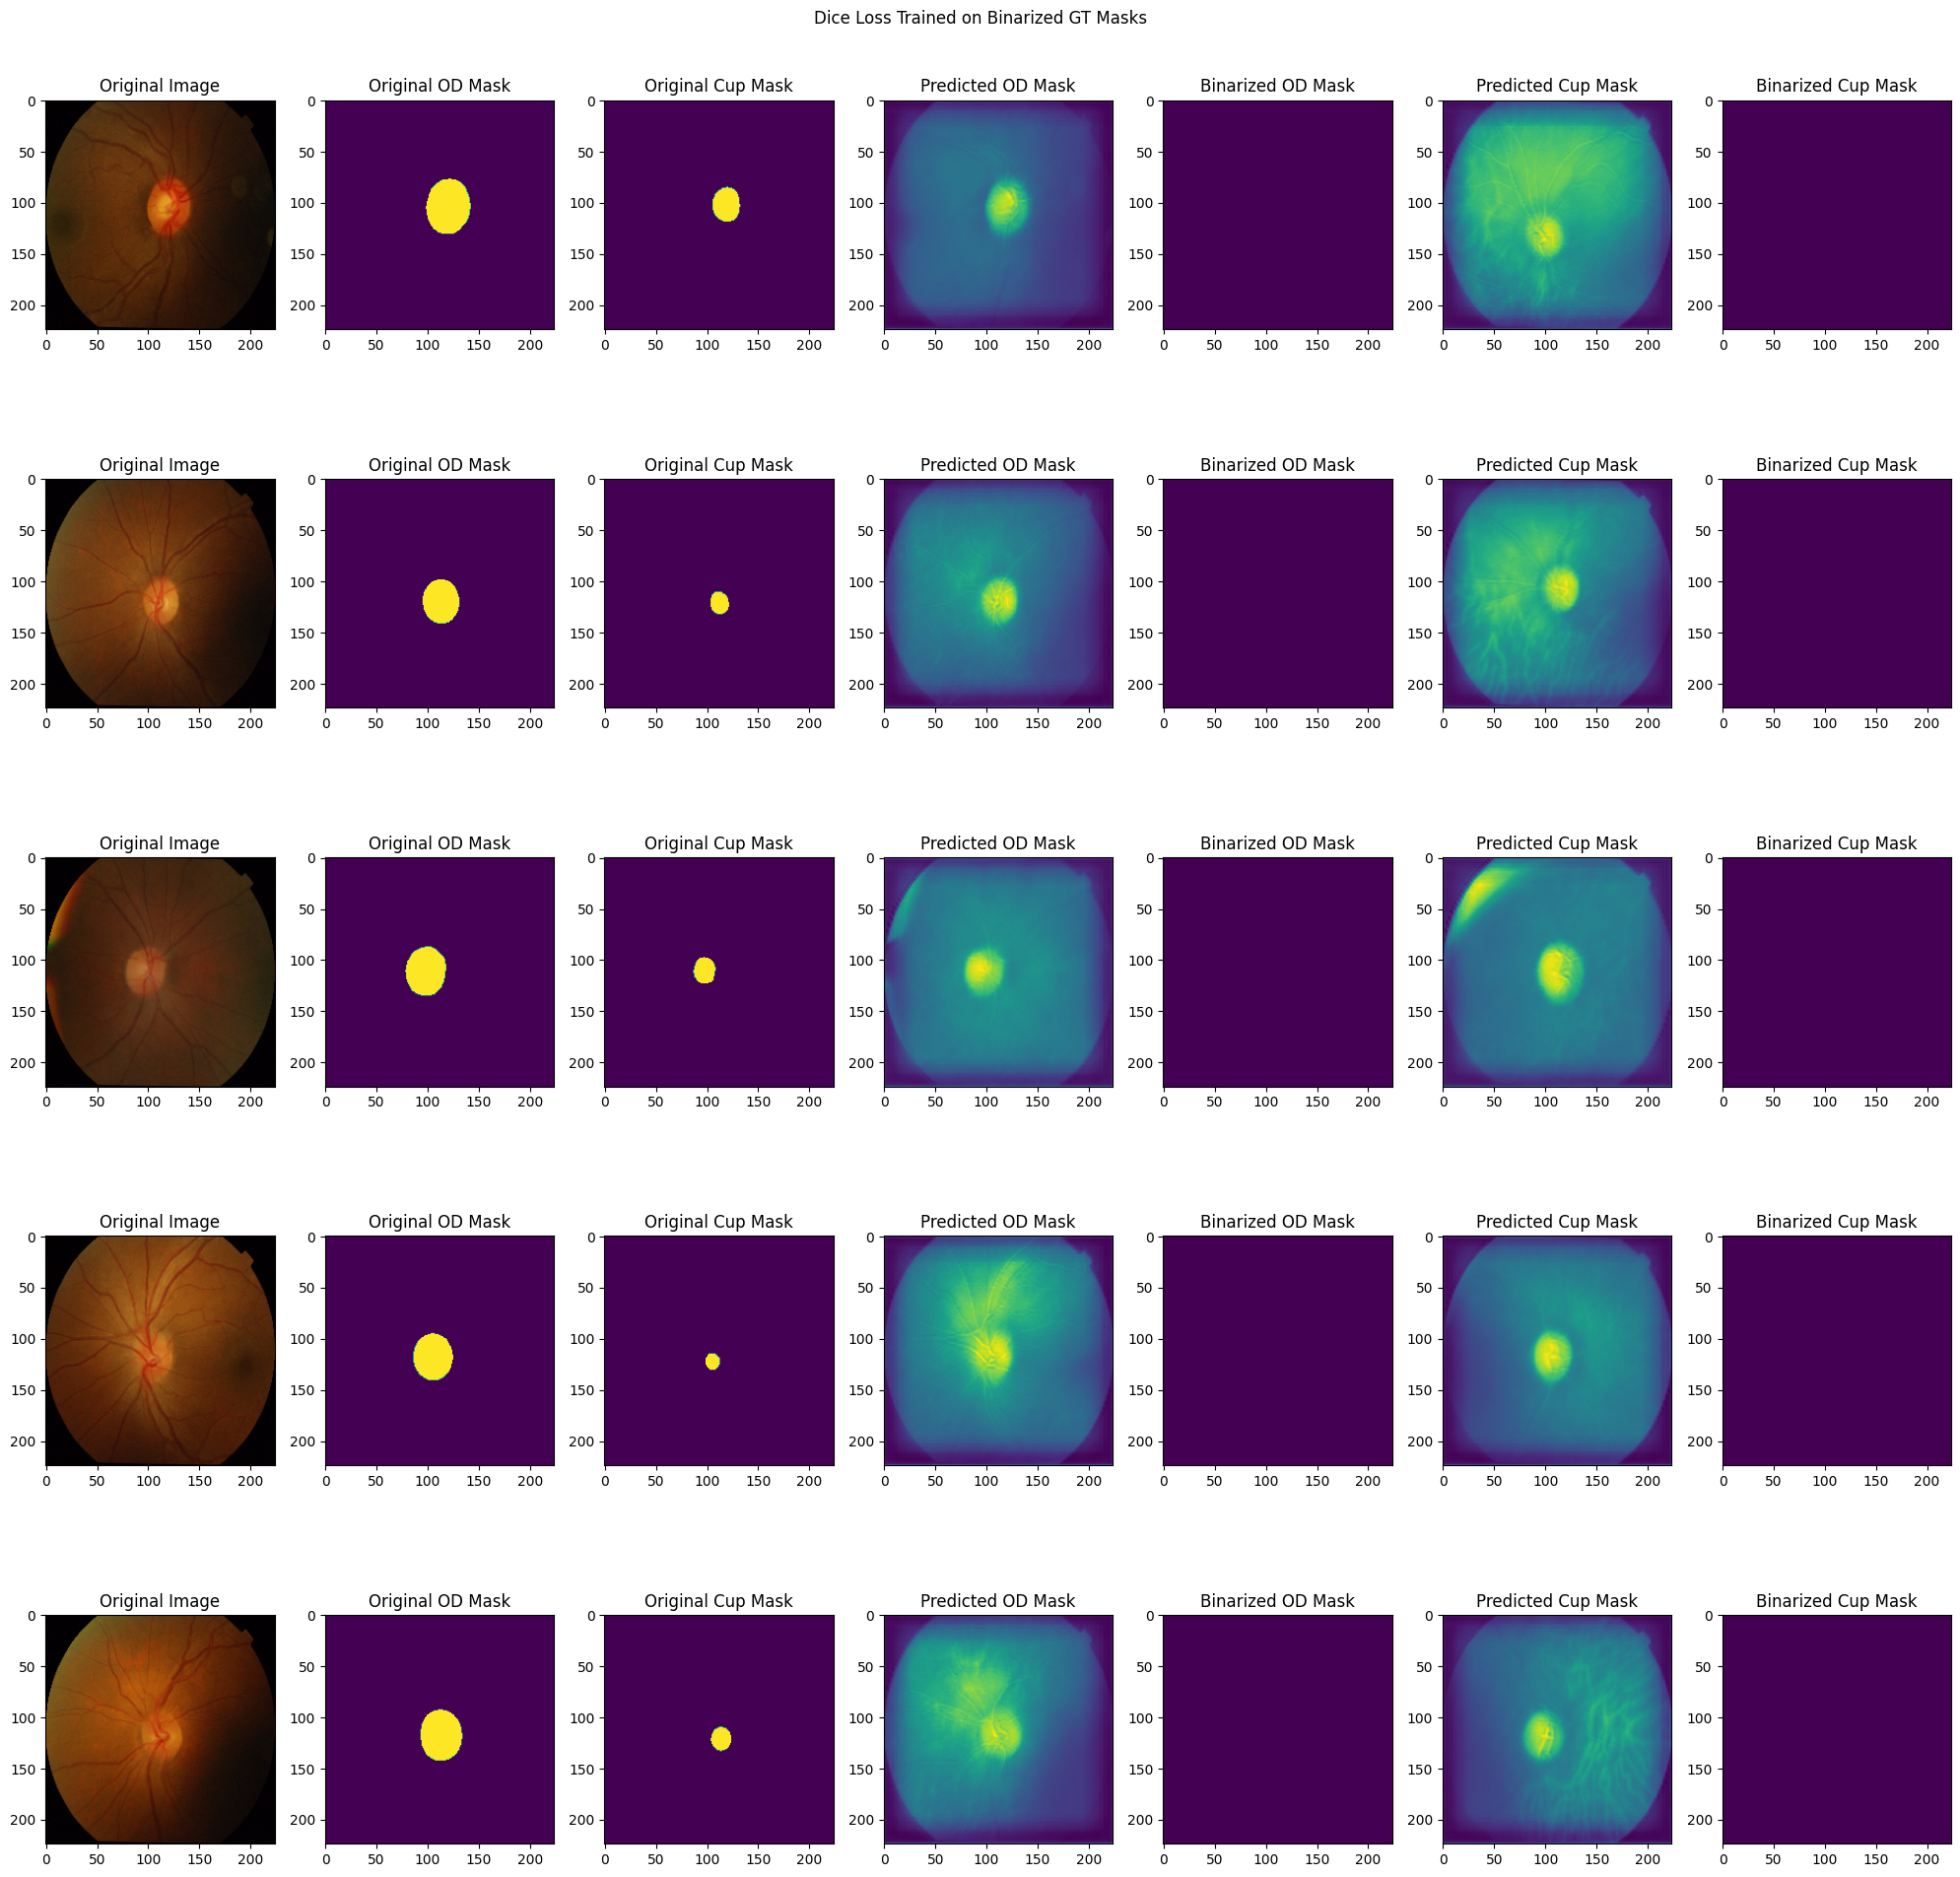

In [58]:
#print(type(predict1))  # 檢查 preds 是什麼類型
#print(predict1)        # 顯示 preds 內容


plt_preds(test_ds_dice, predict1, super_title = 'Dice Loss Trained on Binarized GT Masks', binarizer_threshold = 0.5)

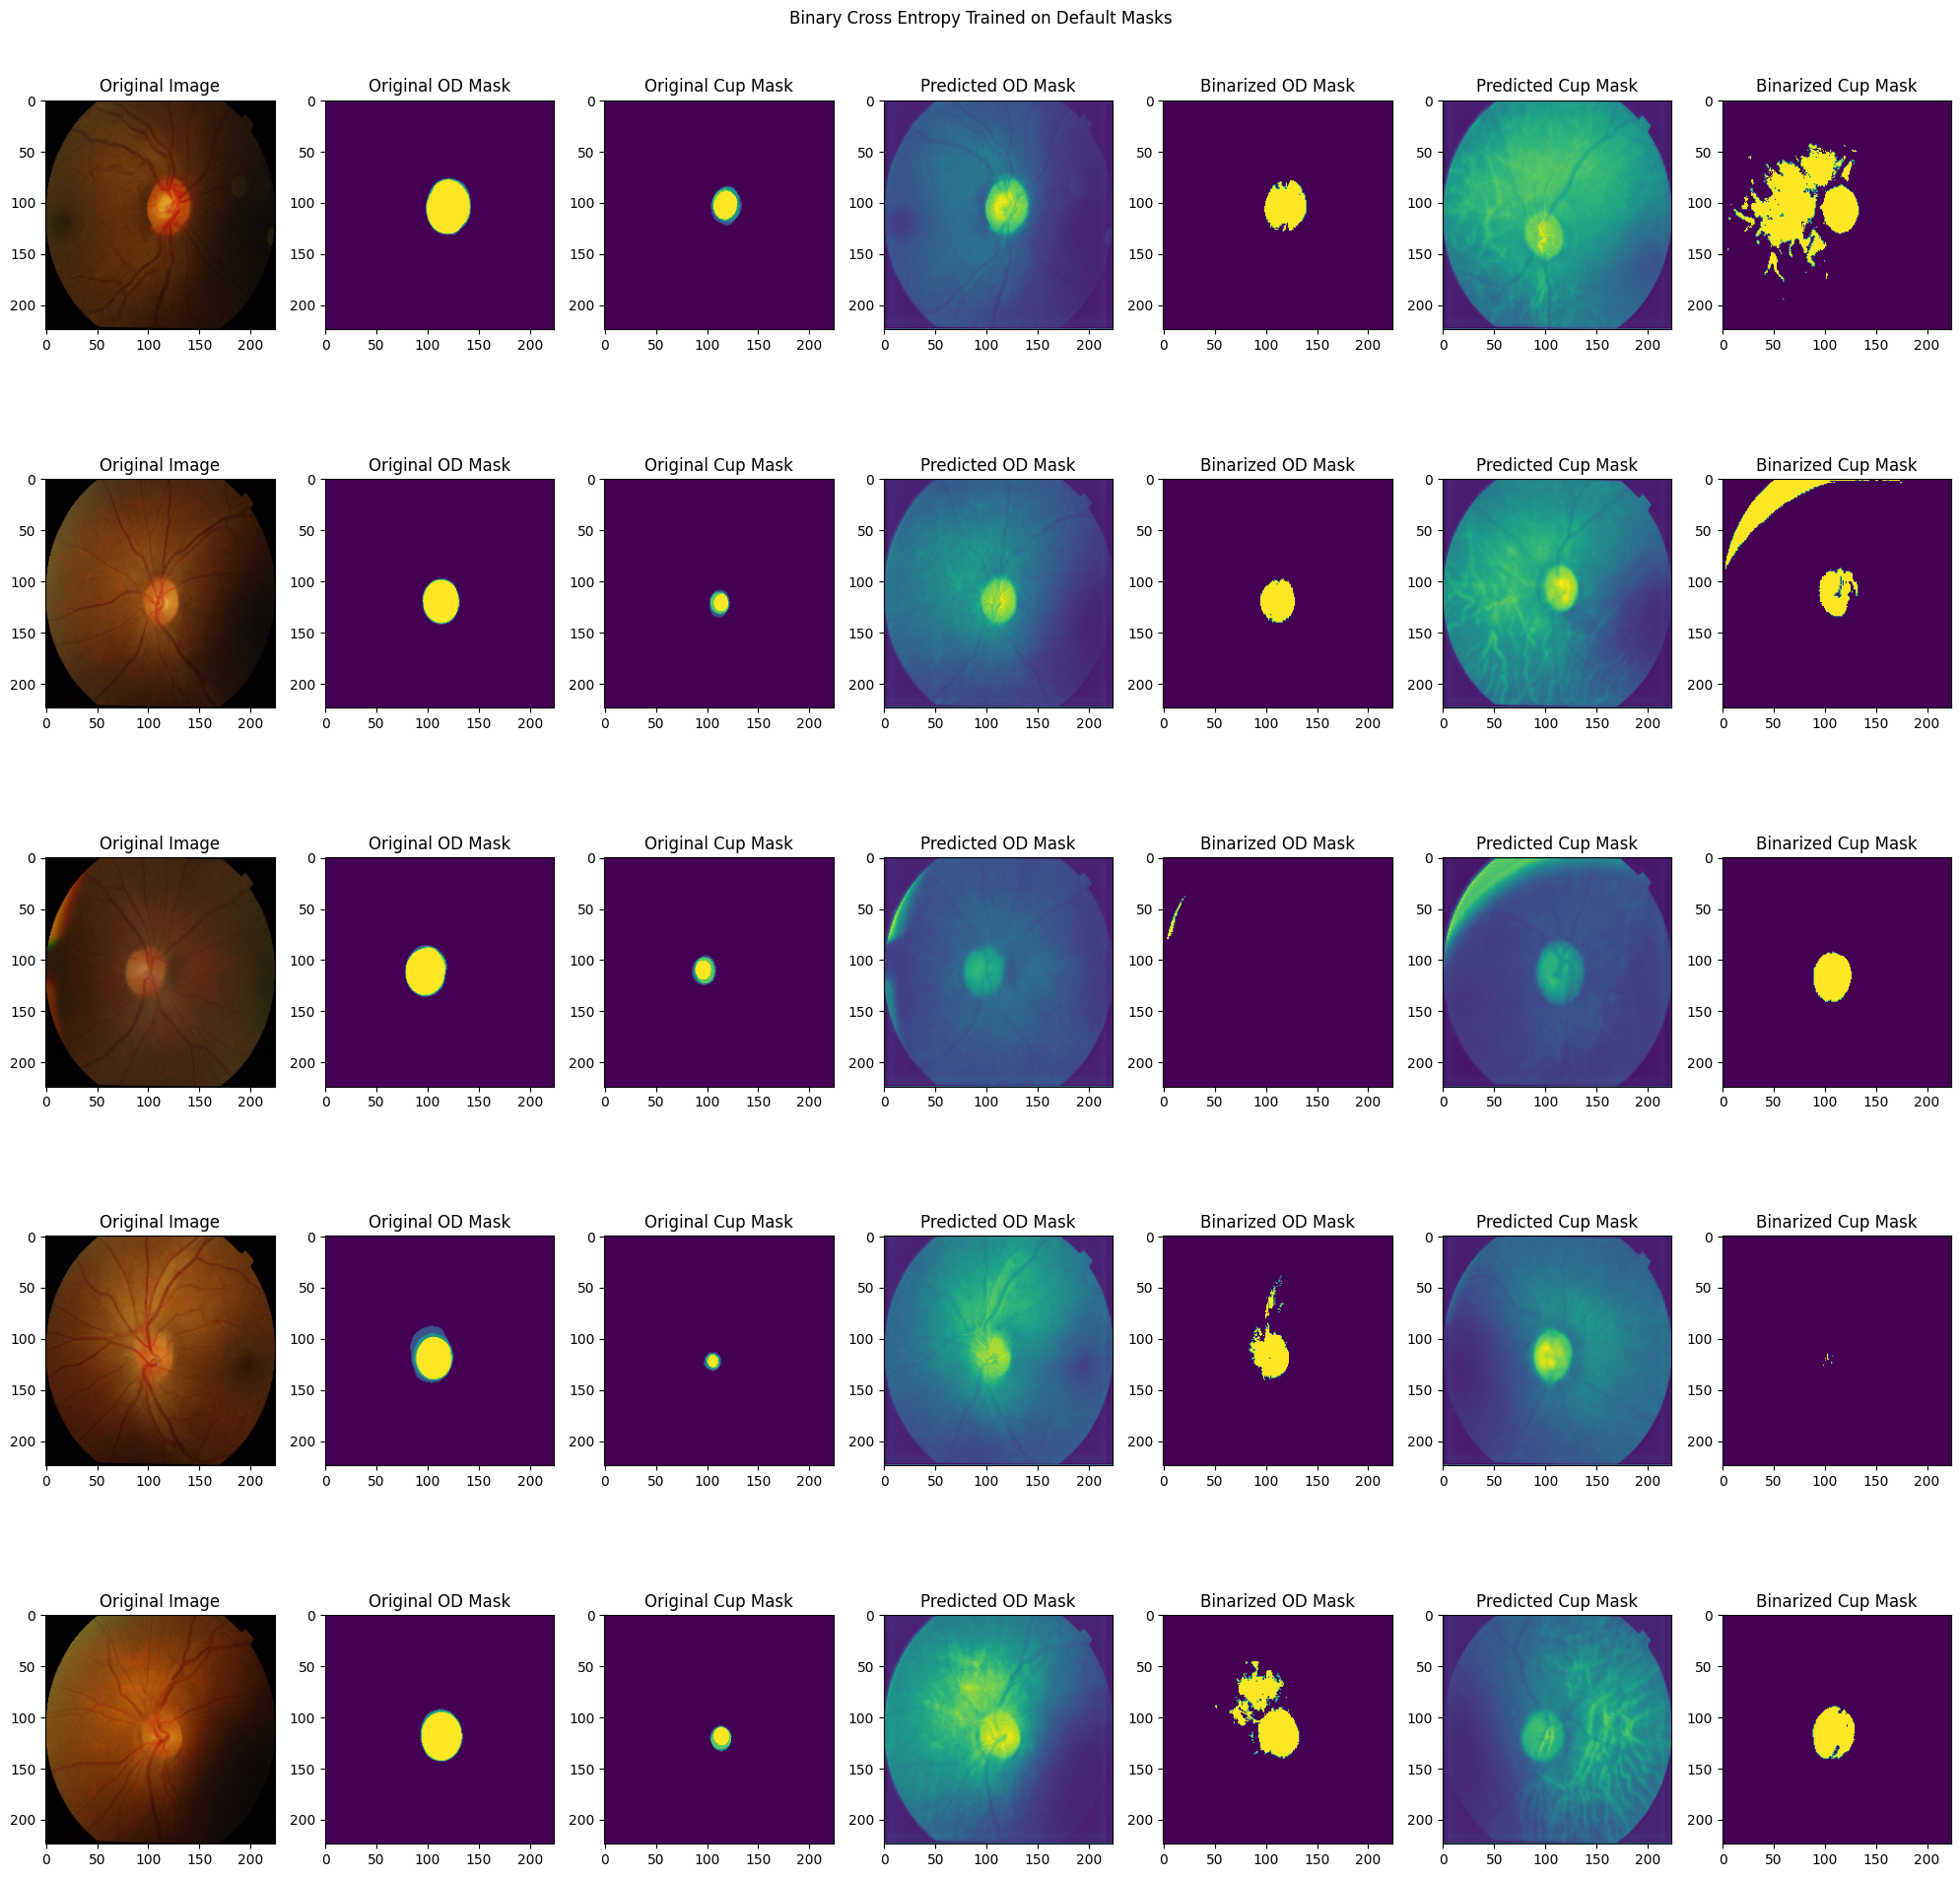

In [59]:
plt_preds(test_ds_no_dice, predict2, binarizer_threshold = 0.25, super_title = 'Binary Cross Entropy Trained on Default Masks')